# **Case Study 2 Data Mining dan Business Intellegence**

## **Model Klasifikasi**

### **Anggota Kelompok B DMDBI (B)**
| No. | Nama | NPM | Kontribusi Pengerjaan |
|:---:|-----|:---:|:---:|
|1.|Achmad Rizki Baehaki|2106725066| Membantu dan menambahkan visualisasi, modelling dan interpretasi
|2.|Christi Novelina Panggabean |2106725021| Membantu dan menambahkan visualisasi, mencoba mencari parameter terbaik
|3.|Delfrin Adiyatma Situmeang|2106759722|  Tangan beliau patah, semoga lekas sembuh
|4.|Faza Fahimatul Ilmiyah|2106638620| Membantu visualisasi, intepretasi dan memberikan insight dari visualisasi
|5.|Jesica Michele Yulianto|2106725002| Membantu preprocessing, visualisasi, mengerjakan tuning hyperparameter, memberikan insight dari visualisasi, serta menyajikan report utama
|6.|Justin Martinus|2106724832| Mengerjakan preprocessing, visualisasi, modelling, cross-validation, serta memberikan insight dari visualisasi dan modelling, serta menyajikan report utama

Keterangan:

**Interpretasi ada di paling bawah**

#Importing Data and Modules (Necessary)

In [ ]:
import warnings; warnings.simplefilter('ignore')
import itertools, re, nltk, pickle
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import time, numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from matplotlib.colors import ListedColormap
from textblob import TextBlob
try:
  from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
except:
  !pip install Sastrawi
  from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode
from nltk.tag import CRFTagger
from html import unescape
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

factory = StopWordRemoverFactory()
stemmer = StemmerFactory().create_stemmer()
sns.set(style="ticks", color_codes=True)
random_state = 170
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
nltk.download('punkt')
try:
  import swifter
except:
  !pip install swifter
  import swifter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Loading Data
import warnings; warnings.simplefilter('ignore')
import pandas as pd

fData = 'data/Data-Hoax-Mafindo.csv'
try:
    df = pd.read_csv(fData)
except:
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/master/data/Data-Hoax-Mafindo.csv
    df = pd.read_csv(fData)

df.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [ ]:
#Importing from github raw content link
github_repo_url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"

# Read the CSV file into a DataFrame
stopwords_dict = pd.read_csv(github_repo_url)

In [ ]:
stopwords_dict.drop(['context', 'category1', 'category2', 'category3', 'In-dictionary'], axis=1, inplace=True)
stopwords_dict.head()

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


#Preprocessing (Long and Unnecessary, but Runnable)

##Checking the Data

In [ ]:
df.dtypes

ID                   int64
label                int64
tanggal             object
judul               object
narasi              object
nama file gambar    object
dtype: object

In [ ]:
df.shape

(4701, 6)

In [ ]:
len(df[df['label']==1]), len(df[df['label']==0])

(3850, 851)

---
Terdapat 3850 hoaks dan 851 berita non-hoaks

##Some Feature Engineering

In [ ]:
df2 = df.copy()
df2['num_hashtags'] = df2['judul'].apply(lambda x: x.count('#'))
df2['num_words'] = df2['judul'].apply(lambda x: len(x.split()))
df2['prop_hashtags'] = df2['num_hashtags'] / df2['num_words']

df2['caps_locked_words'] = df2['judul'].apply(lambda x: sum(word.isupper() for word in x.split()))
df2['prop_caps_locked_words'] = df2['caps_locked_words'] / df2['num_words']

df2 = df2.drop(['num_hashtags', 'caps_locked_words', 'num_words'], axis=1)

In [ ]:
df2['num_hashtags2'] = df2['narasi'].apply(lambda x: x.count('#'))
df2['num_words2'] = df2['narasi'].apply(lambda x: len(x.split()))
df2['prop_hashtags2'] = df2['num_hashtags2'] / df2['num_words2']

df2['caps_locked_words2'] = df2['narasi'].apply(lambda x: sum(word.isupper() for word in x.split()))
df2['prop_caps_locked_words2'] = df2['caps_locked_words2'] / df2['num_words2']

df2 = df2.drop(['num_hashtags2', 'caps_locked_words2', 'num_words2'], axis=1)

##Process the Texts

In [ ]:
judul = df['judul'].apply(lambda x: x.lower())
narasi = df['narasi'].apply(lambda x: x.lower())

In [ ]:
judul

0       pemakaian masker menyebabkan penyakit legionna...
1       instruksi gubernur jateng tentang penilangan  ...
2       foto jim rohn: jokowi adalah presiden terbaik ...
3       ini bukan politik, tapi kenyataan pak jokowi b...
4            foto kadrun kalo lihat foto ini panas dingin
                              ...                        
4696                                 banser-pdip berdamai
4697    erdogan tak mau duduk di kursi tamu yang lebih...
4698    imigran china sengaja membawa virus, tujuannya...
4699                 bukti kecurangan jokowi bagi sembako
4700    anak kecil bersembunyi di kolong meja saat ber...
Name: judul, Length: 4701, dtype: object

In [ ]:
narasi

0       a caller to a radio talk show recently shared ...
1       yth.seluruh anggota grup sesuai instruksi gube...
2       jokowi adalah presiden terbaik dlm sejarah ban...
3       maaf mas2 dan mbak2, ini bukan politik, tapi k...
4             kadrun kalo lihat foto ini panas dingin . .
                              ...                        
4696    ratusan massa dari barisan serba guna (banser)...
4697    erdogan datang ke vatikan menjumpai baba (pop)...
4698    imigran cn sengaja membawa virus dan mereka te...
4699    beredar dimana mana jadi viral video ini\napa ...
4700    naluri anak kecil itu tajam boooss……..\n saat ...
Name: narasi, Length: 4701, dtype: object

In [ ]:
judul = judul.apply(lambda x: unescape(x) if isinstance(x, str) else x)
narasi = narasi.apply(lambda x: unescape(x) if isinstance(x, str) else x)

In [ ]:
def remove_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

# NLTK word rokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

In [ ]:
judul = judul.apply(remove_special)
judul = judul.apply(remove_number)
judul = judul.apply(remove_punctuation)
judul = judul.apply(remove_whitespace_LT)
judul = judul.apply(remove_whitespace_multiple)
judul = judul.apply(remove_singl_char)

In [ ]:
narasi = narasi.apply(remove_special)
narasi = narasi.apply(remove_number)
narasi = narasi.apply(remove_punctuation)
narasi = narasi.apply(remove_whitespace_LT)
narasi = narasi.apply(remove_whitespace_multiple)
narasi = narasi.apply(remove_singl_char)

In [ ]:
token_narasi = narasi.apply(word_tokenize_wrapper)
token_judul = judul.apply(word_tokenize_wrapper)

In [ ]:
def freqDist(text):
    return FreqDist(text)

token_narasi_freq = token_narasi.apply(freqDist)
token_judul_freq = token_judul.apply(freqDist)

In [ ]:
print(token_narasi_freq.head().apply(lambda x : x.most_common()))

0    [(was, 4), (she, 4), (to, 3), (mask, 3), (covi...
1    [(ythseluruh, 1), (anggota, 1), (grup, 1), (se...
2    [(terbaik, 2), (jokowi, 1), (adalah, 1), (pres...
3    [(triliun, 3), (swiss, 3), (siap, 3), (ke, 3),...
4    [(kadrun, 1), (kalo, 1), (lihat, 1), (foto, 1)...
Name: narasi, dtype: object


##StopWords

In [ ]:
judul_ns = judul.copy()
narasi_ns = narasi.copy()

In [ ]:
df_full = df.copy()
df_full.drop(['ID', 'tanggal', 'nama file gambar'], axis=1, inplace=True)
token_narasi = pd.DataFrame(token_narasi)
token_narasi.rename(columns={'narasi': 'token_narasi'}, inplace=True)
token_narasi_freq = pd.DataFrame(token_narasi_freq)
token_narasi_freq.rename(columns={'narasi': 'token_narasi_freq'}, inplace=True)
token_judul = pd.DataFrame(token_judul)
token_judul.rename(columns={'judul': 'token_judul'}, inplace=True)
token_judul_freq = pd.DataFrame(token_judul_freq)
token_judul_freq.rename(columns={'judul': 'token_judul_freq'}, inplace=True)
df_full2 = pd.concat([df_full, token_narasi, token_narasi_freq, token_judul, token_judul_freq], axis=1)

In [ ]:
token_judul_freq

,token_judul_freq
0,"{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1..."
1,"{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '..."
2,"{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ..."
3,"{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1..."
4,"{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1..."
...,...
4696,"{'banserpdip': 1, 'berdamai': 1}"
4697,"{'erdogan': 1, 'tak': 1, 'mau': 1, 'duduk': 1,..."
4698,"{'imigran': 1, 'china': 1, 'sengaja': 1, 'memb..."
4699,"{'bukti': 1, 'kecurangan': 1, 'jokowi': 1, 'ba..."


In [ ]:
df_full2.head()

,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"[caller, to, radio, talk, show, recently, shar...","{'caller': 1, 'to': 3, 'radio': 1, 'talk': 1, ...","[pemakaian, masker, menyebabkan, penyakit, leg...","{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1..."
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"[ythseluruh, anggota, grup, sesuai, instruksi,...","{'ythseluruh': 1, 'anggota': 1, 'grup': 1, 'se...","[instruksi, gubernur, jateng, tentang, penilan...","{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '..."
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"[jokowi, adalah, presiden, terbaik, dlm, sejar...","{'jokowi': 1, 'adalah': 1, 'presiden': 1, 'ter...","[foto, jim, rohn, jokowi, adalah, presiden, te...","{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ..."
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","[maaf, mas, dan, mbak, ini, bukan, politik, ta...","{'maaf': 1, 'mas': 1, 'dan': 1, 'mbak': 1, 'in...","[ini, bukan, politik, tapi, kenyataan, pak, jo...","{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1..."
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"[kadrun, kalo, lihat, foto, ini, panas, dingin]","{'kadrun': 1, 'kalo': 1, 'lihat': 1, 'foto': 1...","[foto, kadrun, kalo, lihat, foto, ini, panas, ...","{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1..."


In [ ]:
df_full = df_full2.copy()

In [ ]:
stopwords_dict.head()

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


In [ ]:
list_stopwords = stopwords.words('indonesian')

list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'ini', 'tapi'])

# convert list to dictionary
list_stopwords = set(list_stopwords)

In [ ]:
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

In [ ]:
katabaku_dict = {}

for index, row in stopwords_dict.iterrows():
    if row[0] not in katabaku_dict:
        katabaku_dict[row[0]] = row[1]

def normalized_term(document):
    return [katabaku_dict[term] if term in katabaku_dict else term for term in document]

In [ ]:
df_full['narasi_formal'] = df_full['token_narasi'].apply(stopwords_removal)

In [ ]:
df_full['narasi_formal'] = df_full['narasi_formal'].apply(normalized_term)

In [ ]:
df_full['narasi_formal'].head()

0    [caller, tapi, radio, talk, show, recently, sh...
1    [ythseluruh, anggota, grup, sesuai, instruksi,...
2    [jokowi, presiden, terbaik, dalam, sejarah, ba...
3    [maaf, mas, mbak, politik, kenyataan, jokowi, ...
4                 [kadrun, lihat, foto, panas, dingin]
Name: narasi_formal, dtype: object

In [ ]:
df_full['judul_formal'] = df_full['token_judul'].apply(stopwords_removal)

In [ ]:
df_full['judul_formal'] = df_full['judul_formal'].apply(normalized_term)

In [ ]:
df_full['judul_formal'].head()

0    [pemakaian, masker, menyebabkan, penyakit, leg...
1    [instruksi, gubernur, jateng, penilangan, berm...
2    [foto, jim, rohn, jokowi, presiden, terbaik, d...
3    [politik, kenyataan, jokowi, berhasil, memulan...
4           [foto, kadrun, lihat, foto, panas, dingin]
Name: judul_formal, dtype: object

##Stemming

In [ ]:
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_full['judul_formal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

for document in df_full['narasi_formal']:
  for term in document:
      if term not in term_dict:
          term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_full['stem_judul'] = df_full['judul_formal'].swifter.apply(get_stemmed_term)
df_full['stem_narasi'] = df_full['narasi_formal'].swifter.apply(get_stemmed_term)

KeyboardInterrupt: ignored

In [ ]:
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict2 = {}

for document2 in df_full2['token_judul']:
    for term in document2:
        if term not in term_dict2:
            term_dict2[term] = ' '

for document2 in df_full2['token_narasi']:
  for term in document2:
      if term not in term_dict2:
          term_dict2[term] = ' '

for term in term_dict2:
    term_dict2[term] = stemmed_wrapper(term)

# apply stemmed term to dataframe
def get_stemmed_term(document2):
    return [term_dict2[term] for term in document2]

df_full2['stem_judul'] = df_full2['token_judul'].swifter.apply(get_stemmed_term)
df_full2['stem_narasi'] = df_full2['token_narasi'].swifter.apply(get_stemmed_term)

##Saving Stemming Results

In [ ]:
df_full.head()

,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"[caller, to, radio, talk, show, recently, shar...","{'caller': 1, 'to': 3, 'radio': 1, 'talk': 1, ...","[pemakaian, masker, menyebabkan, penyakit, leg...","{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1...","[caller, tapi, radio, talk, show, recently, sh...","[pemakaian, masker, menyebabkan, penyakit, leg..."
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"[ythseluruh, anggota, grup, sesuai, instruksi,...","{'ythseluruh': 1, 'anggota': 1, 'grup': 1, 'se...","[instruksi, gubernur, jateng, tentang, penilan...","{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '...","[ythseluruh, anggota, grup, sesuai, instruksi,...","[instruksi, gubernur, jateng, penilangan, berm..."
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"[jokowi, adalah, presiden, terbaik, dlm, sejar...","{'jokowi': 1, 'adalah': 1, 'presiden': 1, 'ter...","[foto, jim, rohn, jokowi, adalah, presiden, te...","{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ...","[jokowi, presiden, terbaik, dalam, sejarah, ba...","[foto, jim, rohn, jokowi, presiden, terbaik, d..."
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","[maaf, mas, dan, mbak, ini, bukan, politik, ta...","{'maaf': 1, 'mas': 1, 'dan': 1, 'mbak': 1, 'in...","[ini, bukan, politik, tapi, kenyataan, pak, jo...","{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1...","[maaf, mas, mbak, politik, kenyataan, jokowi, ...","[politik, kenyataan, jokowi, berhasil, memulan..."
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"[kadrun, kalo, lihat, foto, ini, panas, dingin]","{'kadrun': 1, 'kalo': 1, 'lihat': 1, 'foto': 1...","[foto, kadrun, kalo, lihat, foto, ini, panas, ...","{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1...","[kadrun, lihat, foto, panas, dingin]","[foto, kadrun, lihat, foto, panas, dingin]"


In [ ]:
df_full2.head()

,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"[caller, to, radio, talk, show, recently, shar...","{'caller': 1, 'to': 3, 'radio': 1, 'talk': 1, ...","[pemakaian, masker, menyebabkan, penyakit, leg...","{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1..."
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"[ythseluruh, anggota, grup, sesuai, instruksi,...","{'ythseluruh': 1, 'anggota': 1, 'grup': 1, 'se...","[instruksi, gubernur, jateng, tentang, penilan...","{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '..."
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"[jokowi, adalah, presiden, terbaik, dlm, sejar...","{'jokowi': 1, 'adalah': 1, 'presiden': 1, 'ter...","[foto, jim, rohn, jokowi, adalah, presiden, te...","{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ..."
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","[maaf, mas, dan, mbak, ini, bukan, politik, ta...","{'maaf': 1, 'mas': 1, 'dan': 1, 'mbak': 1, 'in...","[ini, bukan, politik, tapi, kenyataan, pak, jo...","{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1..."
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"[kadrun, kalo, lihat, foto, ini, panas, dingin]","{'kadrun': 1, 'kalo': 1, 'lihat': 1, 'foto': 1...","[foto, kadrun, kalo, lihat, foto, ini, panas, ...","{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1..."


In [ ]:
df_full3 = pd.concat([df_full, df2['prop_hashtags'], df2['prop_caps_locked_words']], axis=1)
df_full3.head()

,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,prop_hashtags,prop_caps_locked_words
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"[caller, to, radio, talk, show, recently, shar...","{'caller': 1, 'to': 3, 'radio': 1, 'talk': 1, ...","[pemakaian, masker, menyebabkan, penyakit, leg...","{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1...","[caller, tapi, radio, talk, show, recently, sh...","[pemakaian, masker, menyebabkan, penyakit, leg...",0.0,0.000000
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"[ythseluruh, anggota, grup, sesuai, instruksi,...","{'ythseluruh': 1, 'anggota': 1, 'grup': 1, 'se...","[instruksi, gubernur, jateng, tentang, penilan...","{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '...","[ythseluruh, anggota, grup, sesuai, instruksi,...","[instruksi, gubernur, jateng, penilangan, berm...",0.0,0.055556
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"[jokowi, adalah, presiden, terbaik, dlm, sejar...","{'jokowi': 1, 'adalah': 1, 'presiden': 1, 'ter...","[foto, jim, rohn, jokowi, adalah, presiden, te...","{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ...","[jokowi, presiden, terbaik, dalam, sejarah, ba...","[foto, jim, rohn, jokowi, presiden, terbaik, d...",0.0,0.000000
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","[maaf, mas, dan, mbak, ini, bukan, politik, ta...","{'maaf': 1, 'mas': 1, 'dan': 1, 'mbak': 1, 'in...","[ini, bukan, politik, tapi, kenyataan, pak, jo...","{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1...","[maaf, mas, mbak, politik, kenyataan, jokowi, ...","[politik, kenyataan, jokowi, berhasil, memulan...",0.0,0.000000
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"[kadrun, kalo, lihat, foto, ini, panas, dingin]","{'kadrun': 1, 'kalo': 1, 'lihat': 1, 'foto': 1...","[foto, kadrun, kalo, lihat, foto, ini, panas, ...","{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1...","[kadrun, lihat, foto, panas, dingin]","[foto, kadrun, lihat, foto, panas, dingin]",0.0,0.000000


In [ ]:
df_full4 = pd.concat([df_full2, df2['prop_hashtags'], df2['prop_caps_locked_words']], axis=1)
df_full4.head()

,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,prop_hashtags,prop_caps_locked_words
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"[caller, to, radio, talk, show, recently, shar...","{'caller': 1, 'to': 3, 'radio': 1, 'talk': 1, ...","[pemakaian, masker, menyebabkan, penyakit, leg...","{'pemakaian': 1, 'masker': 1, 'menyebabkan': 1...",0.0,0.000000
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"[ythseluruh, anggota, grup, sesuai, instruksi,...","{'ythseluruh': 1, 'anggota': 1, 'grup': 1, 'se...","[instruksi, gubernur, jateng, tentang, penilan...","{'instruksi': 1, 'gubernur': 1, 'jateng': 1, '...",0.0,0.055556
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"[jokowi, adalah, presiden, terbaik, dlm, sejar...","{'jokowi': 1, 'adalah': 1, 'presiden': 1, 'ter...","[foto, jim, rohn, jokowi, adalah, presiden, te...","{'foto': 1, 'jim': 1, 'rohn': 1, 'jokowi': 1, ...",0.0,0.000000
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","[maaf, mas, dan, mbak, ini, bukan, politik, ta...","{'maaf': 1, 'mas': 1, 'dan': 1, 'mbak': 1, 'in...","[ini, bukan, politik, tapi, kenyataan, pak, jo...","{'ini': 1, 'bukan': 1, 'politik': 1, 'tapi': 1...",0.0,0.000000
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"[kadrun, kalo, lihat, foto, ini, panas, dingin]","{'kadrun': 1, 'kalo': 1, 'lihat': 1, 'foto': 1...","[foto, kadrun, kalo, lihat, foto, ini, panas, ...","{'foto': 2, 'kadrun': 1, 'kalo': 1, 'lihat': 1...",0.0,0.000000


In [ ]:
df_full.to_csv("Text_Preprocessing_stemmed_no_stop.csv")
df_full3.to_csv("Text_Preprocessing_stemmed_no_stop_with_feature.csv")

In [ ]:
df_full.to_csv("Text_Preprocessing_stemmed_with_stop.csv")
df_full4.to_csv("Text_Preprocessing_stemmed_with_stop_with_feature.csv")

#Preprocessing Part 2 (Necessary)

## Import Saved Data

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1rdztwUGawHyIsSS_acl33rwjqn82lBVO"

path = '/content/data.csv'

try:
  df = pd.read_csv(path)

except:
  gdown.download(url, path, quiet=False)
  df = pd.read_csv(path)

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1kuALj3YmDJ_qwh4rf9YG88o66GCcBbQW"

path = '/content/data2.csv'

try:
  df_with_stop = pd.read_csv(path)

except:
  gdown.download(url, path, quiet=False)
  df_with_stop = pd.read_csv(path)

In [ ]:
df.head()

,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,stem_judul,stem_narasi,prop_hashtags,prop_caps_locked_words
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...","['pakai', 'masker', 'sebab', 'sakit', 'legionn...","['caller', 'tapi', 'radio', 'talk', 'show', 'r...",0.0,0.000000
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...","['instruksi', 'gubernur', 'jateng', 'tilang', ...","['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",0.0,0.055556
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['jokowi', 'presiden', 'baik', 'dalam', 'sejar...",0.0,0.000000
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...","['politik', 'nyata', 'jokowi', 'hasil', 'pulan...","['maaf', 'mas', 'mbak', 'politik', 'nyata', 'j...",0.0,0.000000
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['kadrun', 'lihat', 'foto', 'panas', 'dingin']",0.0,0.000000


### Remove Element

In [ ]:
words_to_remove = {'the', 'if', 'of', 'and'}

def remove_words(text):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

# Menggunakan fungsi apply
df['stem_judul'] = df['stem_judul'].apply(lambda x: remove_words(x))

In [ ]:
words_to_remove = {'the', 'if', 'of', 'and'}

def remove_words(text):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

# Menggunakan fungsi apply
df['stem_narasi'] = df['stem_narasi'].apply(lambda x: remove_words(x))

## TF-IDF

In [ ]:
import ast

def convert_text_list(texts):
    texts = ast.literal_eval(texts)
    return [text for text in texts]

df['judul_TFIDF'] = df['stem_judul'].apply(convert_text_list)
df['narasi_TFIDF'] = df['stem_narasi'].apply(convert_text_list)

In [ ]:
df.head()

,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,stem_judul,stem_narasi,prop_hashtags,prop_caps_locked_words,judul_TFIDF,narasi_TFIDF
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...","['pakai', 'masker', 'sebab', 'sakit', 'legionn...","['caller', 'tapi', 'radio', 'talk', 'show', 'r...",0.0,0.000000,"[pakai, masker, sebab, sakit, legionnaires]","[caller, tapi, radio, talk, show, recently, sh..."
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...","['instruksi', 'gubernur', 'jateng', 'tilang', ...","['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",0.0,0.055556,"[instruksi, gubernur, jateng, tilang, masker, ...","[ythseluruh, anggota, grup, sesuai, instruksi,..."
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['jokowi', 'presiden', 'baik', 'dalam', 'sejar...",0.0,0.000000,"[foto, jim, rohn, jokowi, presiden, baik, dala...","[jokowi, presiden, baik, dalam, sejarah, bangs..."
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...","['politik', 'nyata', 'jokowi', 'hasil', 'pulan...","['maaf', 'mas', 'mbak', 'politik', 'nyata', 'j...",0.0,0.000000,"[politik, nyata, jokowi, hasil, pulang, triliu...","[maaf, mas, mbak, politik, nyata, jokowi, hasi..."
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['kadrun', 'lihat', 'foto', 'panas', 'dingin']",0.0,0.000000,"[foto, kadrun, lihat, foto, panas, dingin]","[kadrun, lihat, foto, panas, dingin]"


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['judul_X'] = df['judul_TFIDF'].apply(lambda x: ' '.join(x))
df['narasi_X'] = df['narasi_TFIDF'].apply(lambda x: ' '.join(x))

In [ ]:
df.head()

,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,stem_judul,stem_narasi,prop_hashtags,prop_caps_locked_words,judul_TFIDF,narasi_TFIDF,judul_X,narasi_X
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...","['pakai', 'masker', 'sebab', 'sakit', 'legionn...","['caller', 'tapi', 'radio', 'talk', 'show', 'r...",0.0,0.000000,"[pakai, masker, sebab, sakit, legionnaires]","[caller, tapi, radio, talk, show, recently, sh...",pakai masker sebab sakit legionnaires,caller tapi radio talk show recently shared th...
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...","['instruksi', 'gubernur', 'jateng', 'tilang', ...","['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",0.0,0.055556,"[instruksi, gubernur, jateng, tilang, masker, ...","[ythseluruh, anggota, grup, sesuai, instruksi,...",instruksi gubernur jateng tilang masker muka r...,ythseluruh anggota grup sesuai instruksi guber...
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['jokowi', 'presiden', 'baik', 'dalam', 'sejar...",0.0,0.000000,"[foto, jim, rohn, jokowi, presiden, baik, dala...","[jokowi, presiden, baik, dalam, sejarah, bangs...",foto jim rohn jokowi presiden baik dalam sejar...,jokowi presiden baik dalam sejarah bangsa indo...
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...","['politik', 'nyata', 'jokowi', 'hasil', 'pulan...","['maaf', 'mas', 'mbak', 'politik', 'nyata', 'j...",0.0,0.000000,"[politik, nyata, jokowi, hasil, pulang, triliu...","[maaf, mas, mbak, politik, nyata, jokowi, hasi...",politik nyata jokowi hasil pulang triliun uang...,maaf mas mbak politik nyata jokowi hasil pulan...
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['kadrun', 'lihat', 'foto', 'panas', 'dingin']",0.0,0.000000,"[foto, kadrun, lihat, foto, panas, dingin]","[kadrun, lihat, foto, panas, dingin]",foto kadrun lihat foto panas dingin,kadrun lihat foto panas dingin


In [ ]:
from scipy.sparse import hstack

In [ ]:
vectorizer = TfidfVectorizer(binary = False, lowercase=True)

df['judul_X'] = df['judul_X'].str.replace("'", "")

df['narasi_X'] = df['narasi_X'].str.replace("'", "")

vsm1 = vectorizer.fit_transform(df['judul_X'])
vsm2 = vectorizer.transform(df['narasi_X'])

In [ ]:
vsm = hstack([vsm1, vsm2])

In [ ]:
vsm

<4701x14304 sparse matrix of type '<class 'numpy.float64'>'
	with 85672 stored elements in Compressed Sparse Row format>

##More Feature Engineering

In [ ]:
url = "https://drive.google.com/uc?id=1wRNzmgsdxTgnKLIxyg8LHLDwcIPYL1Rt"

path = '/content/posi.csv'

try:
  posi = pd.read_csv(path, header=None)

except:
  gdown.download(url, path, quiet=False)
  posi = pd.read_csv(path, header=None)

In [ ]:
url = "https://drive.google.com/uc?id=10ZezszUPsEg2cn2i07LCbRR8l9qbXTOc"

path = '/content/nega.csv'

try:
  nega = pd.read_csv(path, header=None)

except:
  gdown.download(url, path, quiet=False)
  nega = pd.read_csv(path, header=None)

In [ ]:
posi.head()

,0
0,a+
1,acungan jempol
2,adaptif
3,adil
4,afinitas


In [ ]:
df.head()

,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,stem_judul,stem_narasi,prop_hashtags,prop_caps_locked_words,judul_TFIDF,narasi_TFIDF,judul_X,narasi_X
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...","['pakai', 'masker', 'sebab', 'sakit', 'legionn...","['caller', 'tapi', 'radio', 'talk', 'show', 'r...",0.0,0.000000,"[pakai, masker, sebab, sakit, legionnaires]","[caller, tapi, radio, talk, show, recently, sh...",pakai masker sebab sakit legionnaires,caller tapi radio talk show recently shared th...
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...","['instruksi', 'gubernur', 'jateng', 'tilang', ...","['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",0.0,0.055556,"[instruksi, gubernur, jateng, tilang, masker, ...","[ythseluruh, anggota, grup, sesuai, instruksi,...",instruksi gubernur jateng tilang masker muka r...,ythseluruh anggota grup sesuai instruksi guber...
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...","['jokowi', 'presiden', 'baik', 'dalam', 'sejar...",0.0,0.000000,"[foto, jim, rohn, jokowi, presiden, baik, dala...","[jokowi, presiden, baik, dalam, sejarah, bangs...",foto jim rohn jokowi presiden baik dalam sejar...,jokowi presiden baik dalam sejarah bangsa indo...
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...","['politik', 'nyata', 'jokowi', 'hasil', 'pulan...","['maaf', 'mas', 'mbak', 'politik', 'nyata', 'j...",0.0,0.000000,"[politik, nyata, jokowi, hasil, pulang, triliu...","[maaf, mas, mbak, politik, nyata, jokowi, hasi...",politik nyata jokowi hasil pulang triliun uang...,maaf mas mbak politik nyata jokowi hasil pulan...
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...","['kadrun', 'lihat', 'foto', 'panas', 'dingin']",0.0,0.000000,"[foto, kadrun, lihat, foto, panas, dingin]","[kadrun, lihat, foto, panas, dingin]",foto kadrun lihat foto panas dingin,kadrun lihat foto panas dingin


In [ ]:
def count_positive_words(sentence, positive_words):
    return sum(word in sentence for word in positive_words)

# Function to count negative words in a sentence
def count_negative_words(sentence, negative_words):
    return sum(word in sentence for word in negative_words)

In [ ]:
df['judul_X'] = df['judul_X'].astype(str)
df['narasi_X'] = df['narasi_X'].astype(str)
posi[0] = posi[0].astype(str)
nega[0] = nega[0].astype(str)

In [ ]:
df['Positive_Count_Judul'] = df['judul_X'].apply(lambda x: count_positive_words(x, posi[0]))
df['Negative_Count_Judul'] = df['judul_X'].apply(lambda x: count_negative_words(x, nega[0]))

In [ ]:
df['Positive_Count_Narasi'] = df['narasi_X'].apply(lambda x: count_positive_words(x, posi[0]))
df['Negative_Count_Narasi'] = df['narasi_X'].apply(lambda x: count_negative_words(x, nega[0]))

In [ ]:
df.head()

,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,...,prop_hashtags,prop_caps_locked_words,judul_TFIDF,narasi_TFIDF,judul_X,narasi_X,Positive_Count_Judul,Negative_Count_Judul,Positive_Count_Narasi,Negative_Count_Narasi
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...",...,0.0,0.000000,"[pakai, masker, sebab, sakit, legionnaires]","[caller, tapi, radio, talk, show, recently, sh...",pakai masker sebab sakit legionnaires,caller tapi radio talk show recently shared th...,0,1,0,0
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...",...,0.0,0.055556,"[instruksi, gubernur, jateng, tilang, masker, ...","[ythseluruh, anggota, grup, sesuai, instruksi,...",instruksi gubernur jateng tilang masker muka r...,ythseluruh anggota grup sesuai instruksi guber...,0,0,2,0
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...",...,0.0,0.000000,"[foto, jim, rohn, jokowi, presiden, baik, dala...","[jokowi, presiden, baik, dalam, sejarah, bangs...",foto jim rohn jokowi presiden baik dalam sejar...,jokowi presiden baik dalam sejarah bangsa indo...,1,0,1,0
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...",...,0.0,0.000000,"[politik, nyata, jokowi, hasil, pulang, triliu...","[maaf, mas, mbak, politik, nyata, jokowi, hasi...",politik nyata jokowi hasil pulang triliun uang...,maaf mas mbak politik nyata jokowi hasil pulan...,0,1,6,7
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...",...,0.0,0.000000,"[foto, kadrun, lihat, foto, panas, dingin]","[kadrun, lihat, foto, panas, dingin]",foto kadrun lihat foto panas dingin,kadrun lihat foto panas dingin,1,3,1,3


##Splitting X and y

In [ ]:
X = vsm

In [ ]:
y = np.array(df['label']).ravel()

# Visualisasi (Optional)

## Word Cloud

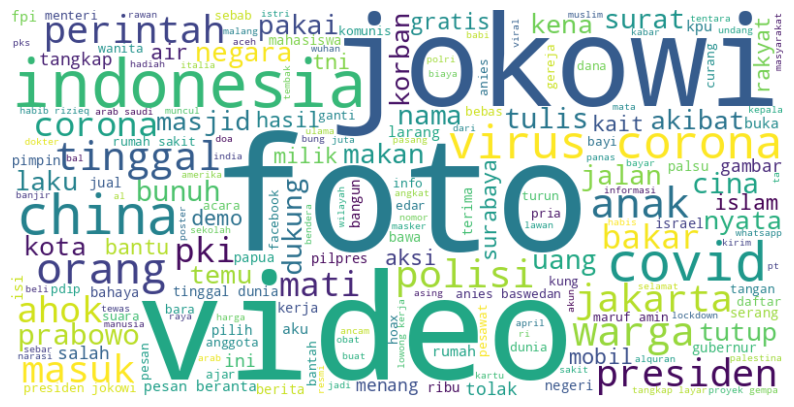

In [ ]:
from wordcloud import WordCloud

# Buat narasi yang hoaks
# Menggabungkan semua nilai dalam kolom "stem_judul" menjadi satu string
semua_teks1 = ' '.join(df[df['label']==1]['judul_X'])

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(semua_teks1)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

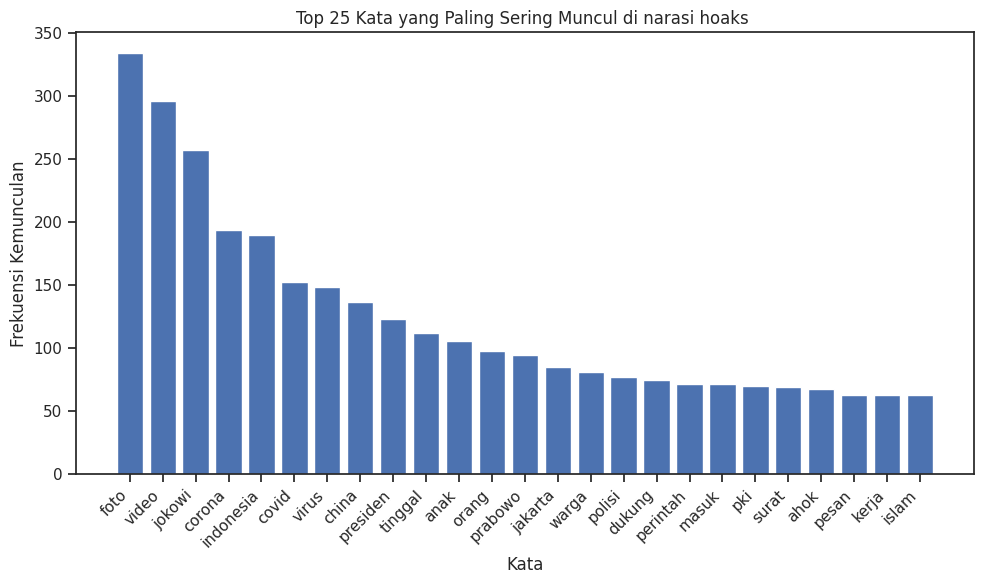

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def plot_top_words(text, num_words=25):
    cleaned_text = re.sub(r'\W+', ' ', text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(num_words)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_words), [count for word, count in top_words], tick_label=[word for word, count in top_words])
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi Kemunculan')
    plt.title(f'Top {num_words} Kata yang Paling Sering Muncul di narasi hoaks ')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#plot
plot_top_words(semua_teks1)

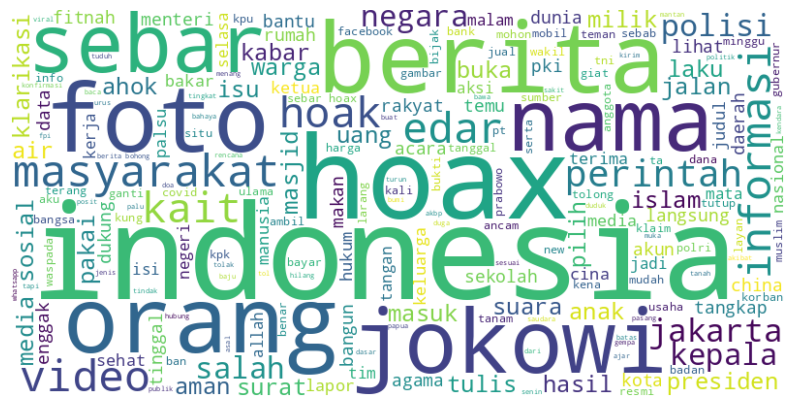

In [ ]:
# Buat narasi yang fakta
# Menggabungkan semua nilai dalam kolom "stem_judul" menjadi satu string
semua_teks2 = ' '.join(df[df['label']==0]['narasi_X'])

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(semua_teks2)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

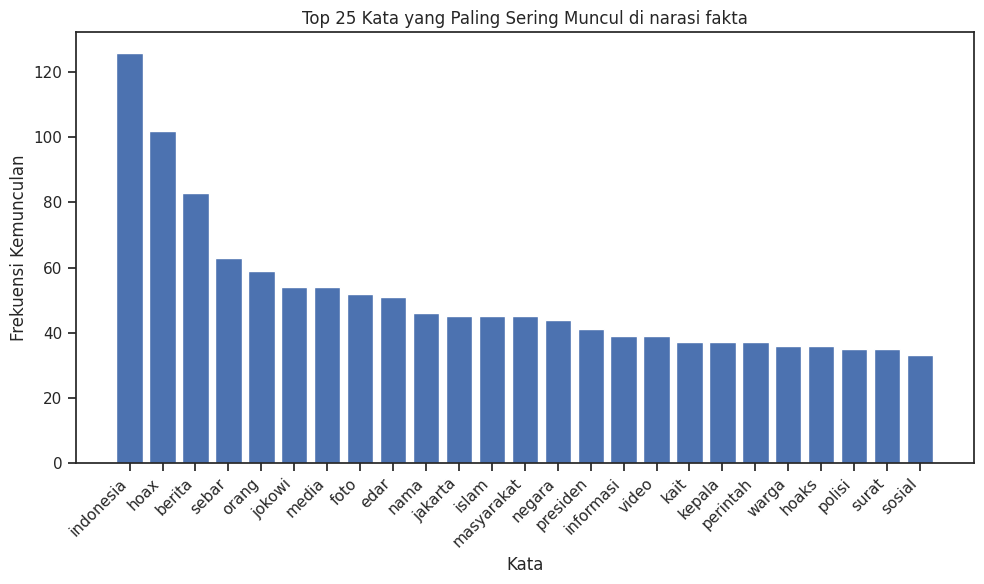

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def plot_top_words(text, num_words=25):
    cleaned_text = re.sub(r'\W+', ' ', text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(num_words)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_words), [count for word, count in top_words], tick_label=[word for word, count in top_words])
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi Kemunculan')
    plt.title(f'Top {num_words} Kata yang Paling Sering Muncul di narasi fakta')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#plot
plot_top_words(semua_teks2)

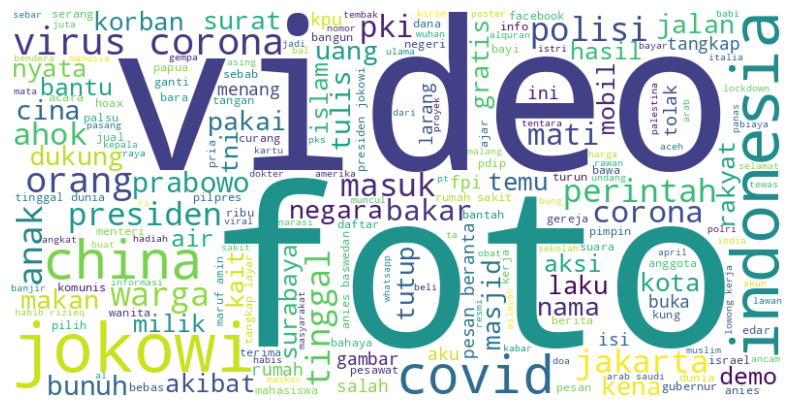

In [ ]:
# Buat judul yang hoaks
# Menggabungkan semua nilai dalam kolom "stem_judul" menjadi satu string
semua_teks3 = ' '.join(df[df['label']==1]['judul_X'])

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(semua_teks3)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

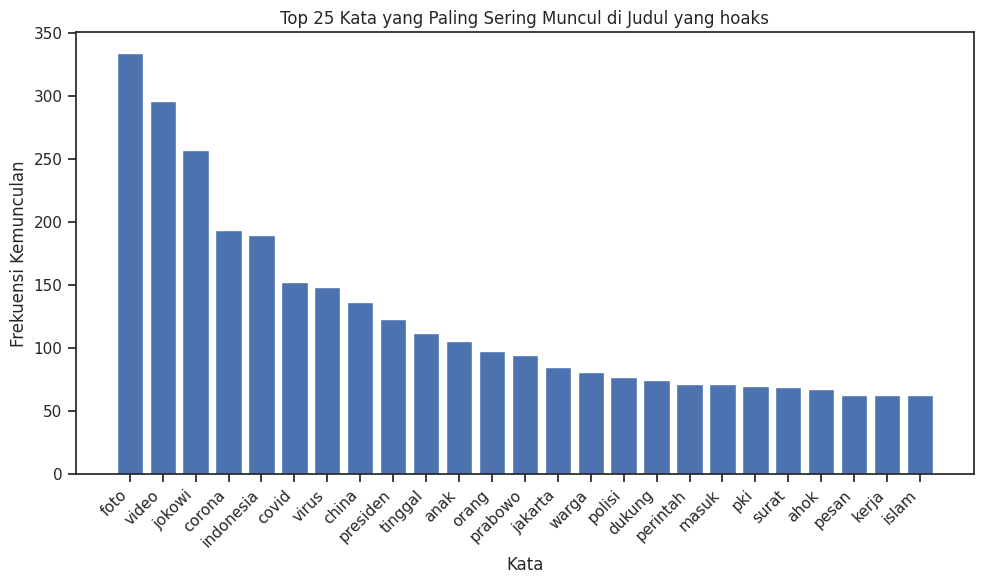

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def plot_top_words(text, num_words=25):
    cleaned_text = re.sub(r'\W+', ' ', text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(num_words)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_words), [count for word, count in top_words], tick_label=[word for word, count in top_words])
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi Kemunculan')
    plt.title(f'Top {num_words} Kata yang Paling Sering Muncul di Judul yang hoaks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#plot
plot_top_words(semua_teks3)

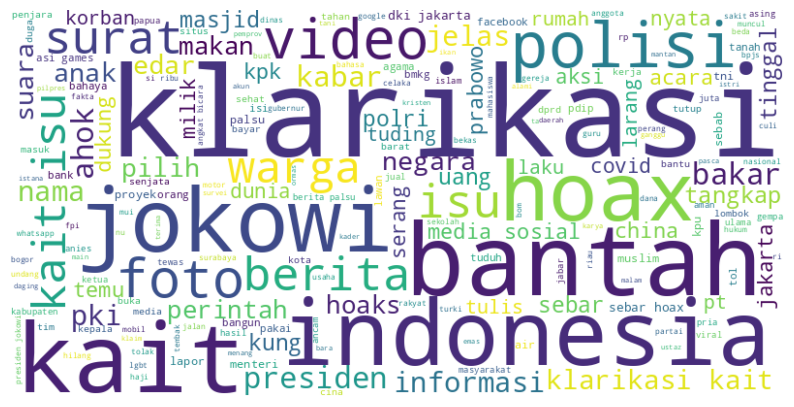

In [ ]:
# Buat judul yang fakta
# Menggabungkan semua nilai dalam kolom "stem_judul" menjadi satu string
semua_teks4 = ' '.join(df[df['label']==0]['judul_X'])

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(semua_teks4)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

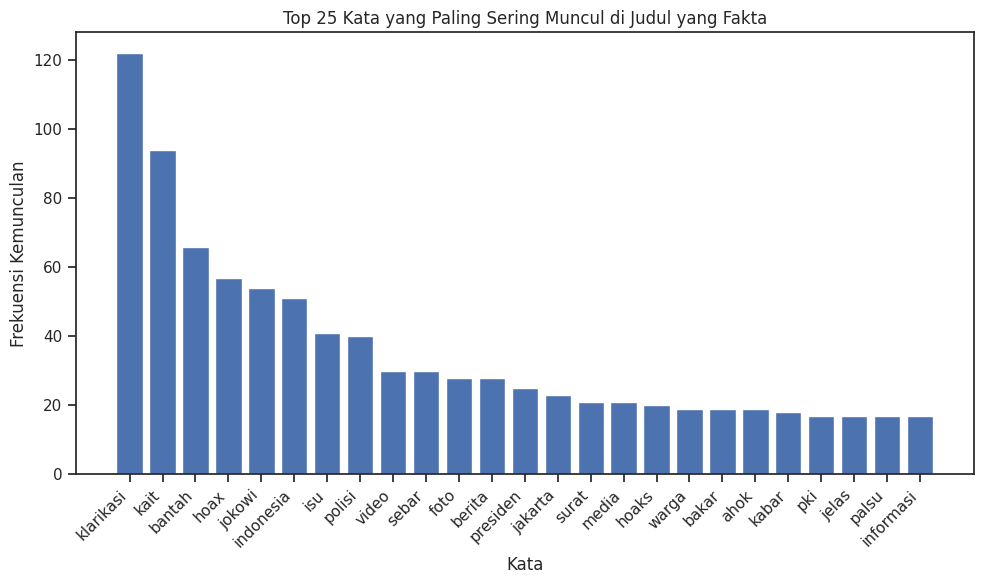

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def plot_top_words(text, num_words=25):
    cleaned_text = re.sub(r'\W+', ' ', text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(num_words)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_words), [count for word, count in top_words], tick_label=[word for word, count in top_words])
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi Kemunculan')
    plt.title(f'Top {num_words} Kata yang Paling Sering Muncul di Judul yang Fakta')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#plot
plot_top_words(semua_teks4)

## Box Plot

Membandingkan panjang kata pada judul dan narasi berdasarkan hoaks atau bukan

In [ ]:
def hitung_panjang_kata(text):
    kata = text.split()
    return len(kata)

df['panjang_kata_judul'] = df['judul'].apply(hitung_panjang_kata)
df['panjang_kata_narasi'] = df['narasi'].apply(hitung_panjang_kata)

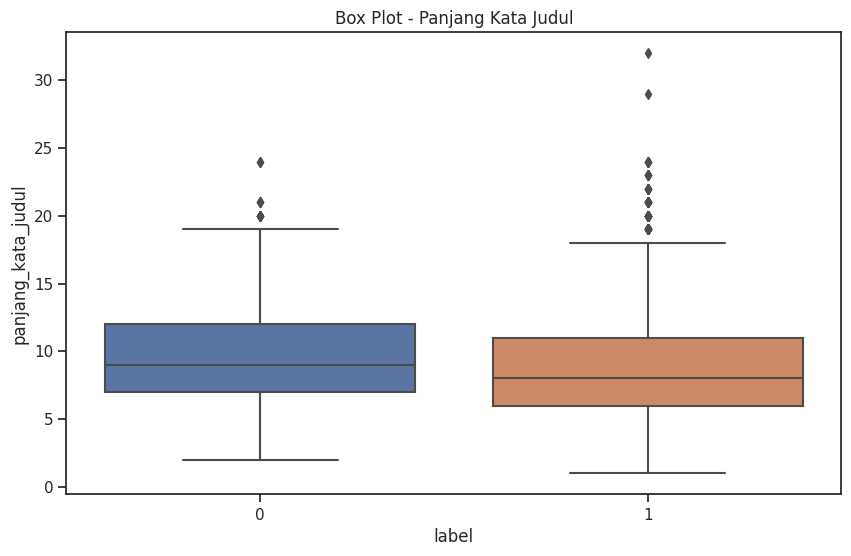

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x= df['label'], y=df['panjang_kata_judul'], data=df)
plt.title('Box Plot - Panjang Kata Judul')
plt.show()

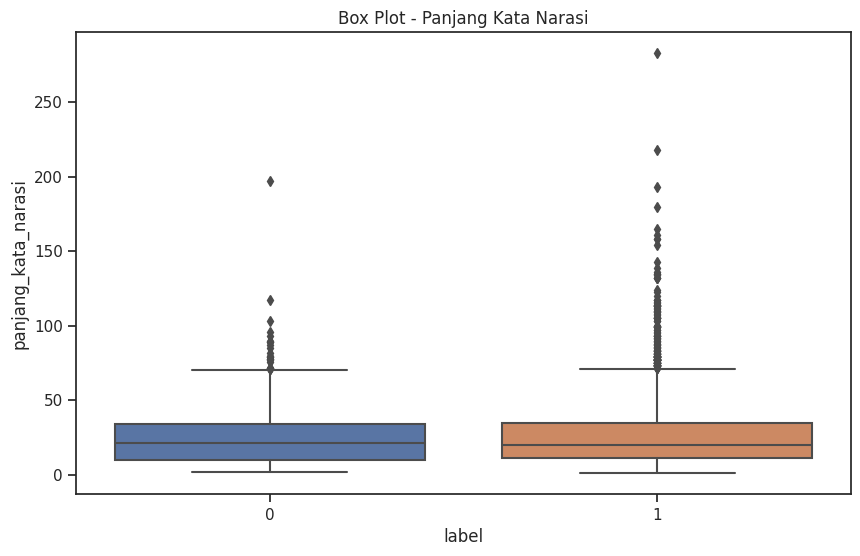

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['label'], y=df['panjang_kata_narasi'], data=df)
plt.title('Box Plot - Panjang Kata Narasi')
plt.show()

## IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(binary = False, lowercase=True)
vectorizer2 = CountVectorizer(binary = False, lowercase=True)
vectorizer1 = CountVectorizer(binary = False, lowercase=True)

vsmidf = vectorizer3.fit_transform(pd.concat([df[df['label']==1]['narasi_X'], df[df['label']==1]['judul_X']]))
vsmidf2 = vectorizer2.fit_transform(df[df['label']==1]['narasi_X'])
vsmidf1 = vectorizer1.fit_transform(df[df['label']==1]['judul_X'])

print(type(vsmidf))
print(type(vsmidf2))
print(type(vsmidf1))
print(vectorizer3.vocabulary_)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
{'caller': 1999, 'tapi': 12198, 'radio': 10018, 'talk': 12134, 'show': 11301, 'recently': 10174, 'shared': 11251, 'that': 12496, 'his': 4519, 'we': 13376, 'was': 13344, 'hospitalized': 4590, 'told': 12670, 'she': 11261, 'had': 4210, 'covid': 2468, 'only': 8728, 'couple': 2462, 'days': 2643, 'left': 6855, 'live': 7042, 'doctor': 3081, 'friend': 3742, 'suggested': 11849, 'be': 1240, 'tested': 12472, 'for': 3695, 'legionnaires': 6863, 'disease': 2988, 'because': 1261, 'wore': 13491, 'same': 10708, 'mask': 7455, 'every': 3486, 'day': 2640, 'all': 365, 'long': 7073, 'turns': 12879, 'out': 8818, 'itu': 5135, 'from': 3743, 'moisture': 7988, 'bacteria': 939, 'ini': 4918, 'her': 4440, 'given': 4019, 'antibiotics': 584, 'within': 13466, 'two': 12899, 'better': 1490, 'what': 13410, 'se': 10901, 'spikes': 11689, 'are': 664, 'really': 10164, 'something': 11615, 'else': 3343, 'due': 3

In [ ]:
# Dilanjutkan dengan membentuk model LDA-nya
from sklearn.decomposition import LatentDirichletAllocation as LDA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
n_topics = 2
lda = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(vsmidf)
n_topics = 3
lda2 = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(vsmidf2)
n_topics = 4
lda1 = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(vsmidf1)

In [ ]:
# Melihat Topik-topiknya
vsm_topics = lda.transform(vsmidf)
print(vsm_topics.shape)
vsm_topics2 = lda2.transform(vsmidf2)
print(vsm_topics2.shape)
vsm_topics1 = lda1.transform(vsmidf1)
print(vsm_topics2.shape)
vsm_topics[:10]
# Ukuran kolom = #Topics ==> Dimension Reduction

(7700, 2)
(3850, 3)
(3850, 3)


array([[0.99215241, 0.00784759],
       [0.56520053, 0.43479947],
       [0.06129994, 0.93870006],
       [0.8358119 , 0.1641881 ],
       [0.09700393, 0.90299607],
       [0.19872786, 0.80127214],
       [0.1599675 , 0.8400325 ],
       [0.73724373, 0.26275627],
       [0.90530194, 0.09469806],
       [0.03238533, 0.96761467]])

100%|██████████| 7700/7700 [00:00<00:00, 747492.03it/s]


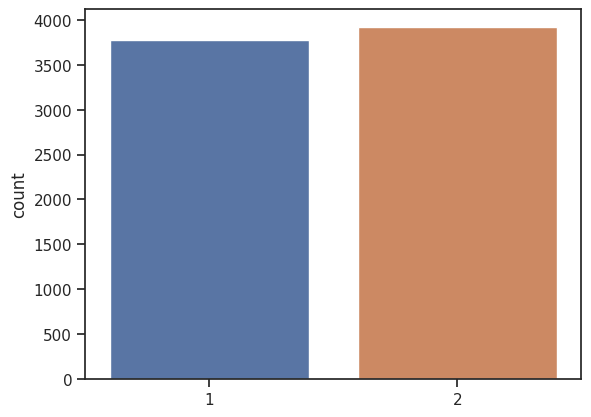

In [ ]:
# Seandainya diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
p = sns.countplot(x=doc_topic)

In [ ]:
try:
  !pip install pandas==1.5.3
  import pyLDAvis
  import pyLDAvis.lda_model
  import pyLDAvis.gensim
  import pyLDAvis.gensim_models as gensimvis
  pyLDAvis.enable_notebook()
except:
  !pip install pyLDAvis
  import pyLDAvis
  import pyLDAvis.lda_model
  import pyLDAvis.gensim
  import pyLDAvis.gensim_models as gensimvis
  pyLDAvis.enable_notebook()
  !pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 38.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
pyLDAvis.lda_model.prepare(lda1, vsmidf1, vectorizer1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.043219  0.125896       1        1  28.326087
2     -0.101136 -0.102399       2        1  25.176258
1      0.008622  0.013577       3        1  23.276678
0      0.135732 -0.037074       4        1  23.220977, topic_info=          Term        Freq       Total Category  logprob  loglift
2487    jokowi  207.000000  207.000000  Default  30.0000  30.0000
81         air   46.000000   46.000000  Default  29.0000  29.0000
6153     virus  119.000000  119.000000  Default  28.0000  28.0000
1131    corona  155.000000  155.000000  Default  27.0000  27.0000
1139     covid  122.000000  122.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3140    larang   14.328275   28.718102   Topic4  -6.0166   0.7648
1673      foto   24.870703  268.113597   Topic4  -5.4652  -0.9176
4531  presiden   18.286317   99.659044   Topic4  -5.7727  -0.2355
102     akibat   15.070193   41.497015   Topic4  -5.9661   0.4472
4410       pki   15.359852   56.810664   Topic4  -5.9471   0.1521

[284 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
9         1  0.972695   abdul
29        3  0.899145  adakan
53        1  0.904132   agama
53        3  0.033486   agama
53        4  0.066973   agama
...     ...       ...     ...
6206      3  0.167304   warga
6206      4  0.076047   warga
6247      1  0.907908  widodo
6323      1  0.885028  yusril
6352      4  0.916985    zona

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [ ]:
pyLDAvis.lda_model.prepare(lda2, vsmidf2, vectorizer2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.024312 -0.096053       1        1  37.135123
0     -0.096543  0.027272       2        1  31.746792
2      0.072232  0.068781       3        1  31.118084, topic_info=            Term        Freq       Total Category  logprob  loglift
2284      corona  198.000000  198.000000  Default  30.0000  30.0000
2068       china  166.000000  166.000000  Default  29.0000  29.0000
12371      virus  220.000000  220.000000  Default  28.0000  28.0000
11857        tni   91.000000   91.000000  Default  27.0000  27.0000
6794       makan   95.000000   95.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8210       orang   70.525473  380.065412   Topic3  -5.6148  -0.5170
4556   indonesia   69.128963  404.082568   Topic3  -5.6348  -0.5983
9421      rakyat   43.469561  123.984003   Topic3  -6.0987   0.1193
8713    perintah   43.972132  138.792415   Topic3  -6.0872   0.0180
6278        laku   37.735962   99.459213   Topic3  -6.2401   0.1982

[259 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
52         1  0.101184     aceh
52         2  0.860062     aceh
112        3  0.957203    adzan
157        1  0.105582  agustus
157        2  0.844658  agustus
...      ...       ...      ...
12499      2  0.195558    warga
12499      3  0.170050    warga
12592      2  0.243688   widodo
12592      3  0.761524   widodo
12832      3  0.947103     zeal

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## Barplot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


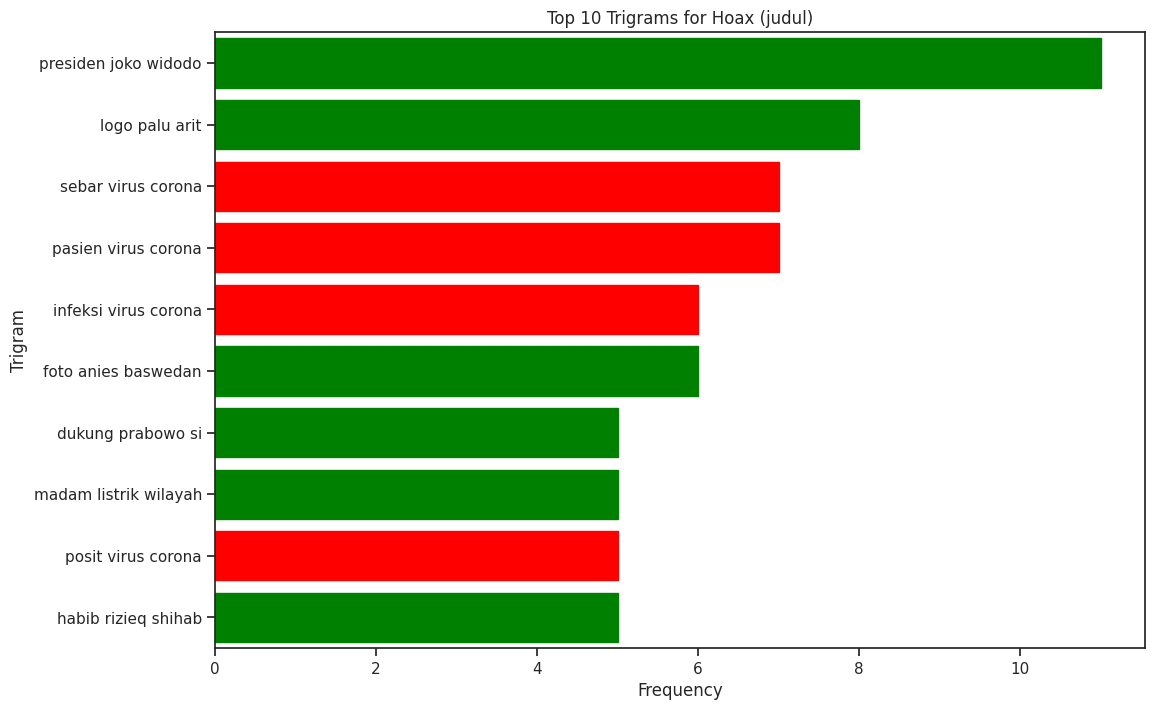

In [ ]:
#Untuk bagian Judul

import nltk
from nltk import ngrams
from collections import Counter

hoax_texts = df[df['label'] == 1]['judul_X']

all_text = ' '.join(hoax_texts)
def generate_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

trigrams = generate_ngrams(all_text, 3)
trigram_freq = Counter(trigrams)
trigram_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency'])

trigram_df = trigram_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Trigram', data=trigram_df.head(10))

highlighted_trigrams = ["sebar virus corona", "pasien virus corona", "infeksi virus corona", "posit virus corona"]
colors = ['red' if trigram in highlighted_trigrams else 'green' for trigram in trigram_df['Trigram']]

for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

plt.title('Top 10 Trigrams for Hoax (judul)')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


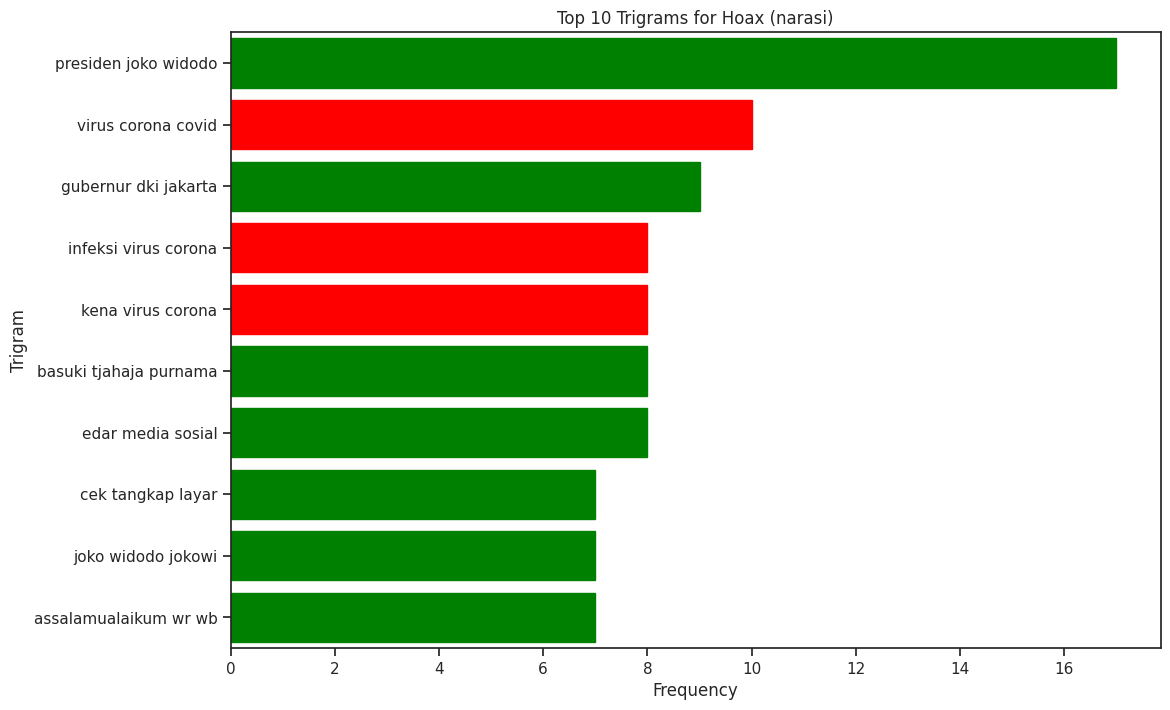

In [ ]:
# Untuk bagian narasi

hoax_texts = df[df['label'] == 1]['narasi_X']

all_text = ' '.join(hoax_texts)
def generate_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

#UNTUK NARASI


trigrams = generate_ngrams(all_text, 3)
trigram_freq = Counter(trigrams)
trigram_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency'])

trigram_df = trigram_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Trigram', data=trigram_df.head(10))

highlighted_trigrams = ["virus corona covid", "infeksi virus corona", "kena virus corona"]
colors = ['red' if trigram in highlighted_trigrams else 'green' for trigram in trigram_df['Trigram']]

for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

plt.title('Top 10 Trigrams for Hoax (narasi)')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

##Pie Chart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Presentase Sentimen pada Narasi Berita Hoax')

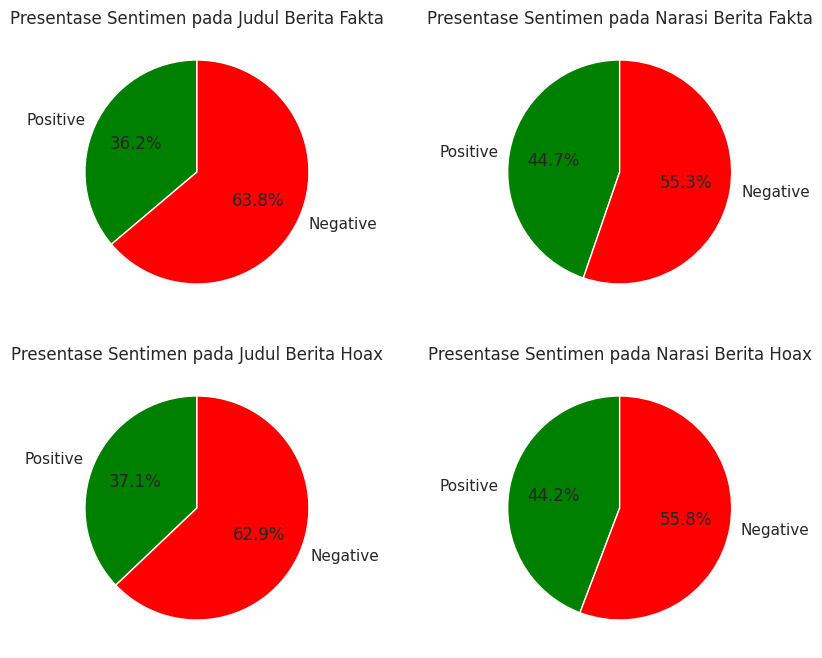

In [ ]:
#Membuat df
sentimen_judul_fakta = df[df['label']==0][['Positive_Count_Judul','Negative_Count_Judul']]
sentimen_narasi_fakta = df[df['label']==0][['Positive_Count_Narasi','Negative_Count_Narasi']]
sentimen_judul_hoax = df[df['label']==1][['Positive_Count_Judul','Negative_Count_Judul']]
sentimen_narasi_hoax = df[df['label']==1][['Positive_Count_Narasi','Negative_Count_Narasi']]

# Sum each column
sum_positive1 = sentimen_judul_fakta['Positive_Count_Judul'].sum()
sum_negative1 = sentimen_judul_fakta['Negative_Count_Judul'].sum()
sum_positive2 = sentimen_narasi_fakta['Positive_Count_Narasi'].sum()
sum_negative2 = sentimen_narasi_fakta['Negative_Count_Narasi'].sum()
sum_positive3 = sentimen_judul_hoax['Positive_Count_Judul'].sum()
sum_negative3 = sentimen_judul_hoax['Negative_Count_Judul'].sum()
sum_positive4 = sentimen_narasi_hoax['Positive_Count_Narasi'].sum()
sum_negative4 = sentimen_narasi_hoax['Negative_Count_Narasi'].sum()

labels = ['Positive', 'Negative']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].pie([sum_positive1, sum_negative1], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0, 0].set_title('Presentase Sentimen pada Judul Berita Fakta')

axs[0, 1].pie([sum_positive2, sum_negative2], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0, 1].set_title('Presentase Sentimen pada Narasi Berita Fakta')

axs[1, 0].pie([sum_positive3, sum_negative3], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1, 0].set_title('Presentase Sentimen pada Judul Berita Hoax')

axs[1, 1].pie([sum_positive4, sum_negative4], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1, 1].set_title('Presentase Sentimen pada Narasi Berita Hoax')

In [ ]:
sentimen0 = df[df['label']==0][['Positive_Count_Judul','Negative_Count_Judul','Positive_Count_Narasi','Negative_Count_Narasi']]
sentimen1 = df[df['label']==1][['Positive_Count_Judul','Negative_Count_Judul','Positive_Count_Narasi','Negative_Count_Narasi']]
total_counts0 = sentimen0.sum(axis=0)
total_counts1 = sentimen1.sum(axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Jumlah Sentimen Counts pada Berita Fakta
total_counts0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Positive_Count_Judul      404
Negative_Count_Judul      713
Positive_Count_Narasi    1078
Negative_Count_Narasi    1331
dtype: int64

In [ ]:
#Jumlah Sentimen Counts pada Berita Hoax
total_counts1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Positive_Count_Judul     1615
Negative_Count_Judul     2738
Positive_Count_Narasi    5085
Negative_Count_Narasi    6411
dtype: int64

##DateTime

In [ ]:
df_2 = pd.read_csv(fData)
df_2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,label,judul,narasi,token_narasi,token_narasi_freq,token_judul,token_judul_freq,narasi_formal,judul_formal,...,judul_TFIDF,narasi_TFIDF,judul_X,narasi_X,Positive_Count_Judul,Negative_Count_Judul,Positive_Count_Narasi,Negative_Count_Narasi,panjang_kata_judul,panjang_kata_narasi
0,0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,"['caller', 'to', 'radio', 'talk', 'show', 'rec...",<FreqDist with 63 samples and 80 outcomes>,"['pemakaian', 'masker', 'menyebabkan', 'penyak...",<FreqDist with 5 samples and 5 outcomes>,"['caller', 'tapi', 'radio', 'talk', 'show', 'r...","['pemakaian', 'masker', 'menyebabkan', 'penyak...",...,"[pakai, masker, sebab, sakit, legionnaires]","[caller, tapi, radio, talk, show, recently, sh...",pakai masker sebab sakit legionnaires,caller tapi radio talk show recently shared th...,0,1,0,0,5,93
1,1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...",<FreqDist with 16 samples and 16 outcomes>,"['instruksi', 'gubernur', 'jateng', 'tentang',...",<FreqDist with 18 samples and 18 outcomes>,"['ythseluruh', 'anggota', 'grup', 'sesuai', 'i...","['instruksi', 'gubernur', 'jateng', 'penilanga...",...,"[instruksi, gubernur, jateng, tilang, masker, ...","[ythseluruh, anggota, grup, sesuai, instruksi,...",instruksi gubernur jateng tilang masker muka r...,ythseluruh anggota grup sesuai instruksi guber...,0,0,2,0,18,17
2,2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,"['jokowi', 'adalah', 'presiden', 'terbaik', 'd...",<FreqDist with 12 samples and 13 outcomes>,"['foto', 'jim', 'rohn', 'jokowi', 'adalah', 'p...",<FreqDist with 11 samples and 11 outcomes>,"['jokowi', 'presiden', 'terbaik', 'dalam', 'se...","['foto', 'jim', 'rohn', 'jokowi', 'presiden', ...",...,"[foto, jim, rohn, jokowi, presiden, baik, dala...","[jokowi, presiden, baik, dalam, sejarah, bangs...",foto jim rohn jokowi presiden baik dalam sejar...,jokowi presiden baik dalam sejarah bangsa indo...,1,0,1,0,11,13
3,3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...","['maaf', 'mas', 'dan', 'mbak', 'ini', 'bukan',...",<FreqDist with 91 samples and 111 outcomes>,"['ini', 'bukan', 'politik', 'tapi', 'kenyataan...",<FreqDist with 14 samples and 14 outcomes>,"['maaf', 'mas', 'mbak', 'politik', 'kenyataan'...","['politik', 'kenyataan', 'jokowi', 'berhasil',...",...,"[politik, nyata, jokowi, hasil, pulang, triliu...","[maaf, mas, mbak, politik, nyata, jokowi, hasi...",politik nyata jokowi hasil pulang triliun uang...,maaf mas mbak politik nyata jokowi hasil pulan...,0,1,6,7,15,117
4,4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,"['kadrun', 'kalo', 'lihat', 'foto', 'ini', 'pa...",<FreqDist with 7 samples and 7 outcomes>,"['foto', 'kadrun', 'kalo', 'lihat', 'foto', 'i...",<FreqDist with 7 samples and 8 outcomes>,"['kadrun', 'lihat', 'foto', 'panas', 'dingin']","['foto', 'kadrun', 'lihat', 'foto', 'panas', '...",...,"[foto, kadrun, lihat, foto, panas, dingin]","[kadrun, lihat, foto, panas, dingin]",foto kadrun lihat foto panas dingin,kadrun lihat foto panas dingin,1,3,1,3,8,9


In [ ]:
df_date = pd.merge(df_2[['tanggal', 'label']], df[['narasi_TFIDF', 'judul_TFIDF', 'narasi_X', 'judul_X', 'label']], on='label')
df_date.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tanggal,label,narasi_TFIDF,judul_TFIDF,narasi_X,judul_X
0,17-Aug-20,1,"[caller, tapi, radio, talk, show, recently, sh...","[pakai, masker, sebab, sakit, legionnaires]",caller tapi radio talk show recently shared th...,pakai masker sebab sakit legionnaires
1,17-Aug-20,1,"[ythseluruh, anggota, grup, sesuai, instruksi,...","[instruksi, gubernur, jateng, tilang, masker, ...",ythseluruh anggota grup sesuai instruksi guber...,instruksi gubernur jateng tilang masker muka r...
2,17-Aug-20,1,"[jokowi, presiden, baik, dalam, sejarah, bangs...","[foto, jim, rohn, jokowi, presiden, baik, dala...",jokowi presiden baik dalam sejarah bangsa indo...,foto jim rohn jokowi presiden baik dalam sejar...
3,17-Aug-20,1,"[maaf, mas, mbak, politik, nyata, jokowi, hasi...","[politik, nyata, jokowi, hasil, pulang, triliu...",maaf mas mbak politik nyata jokowi hasil pulan...,politik nyata jokowi hasil pulang triliun uang...
4,17-Aug-20,1,"[kadrun, lihat, foto, panas, dingin]","[foto, kadrun, lihat, foto, panas, dingin]",kadrun lihat foto panas dingin,foto kadrun lihat foto panas dingin


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


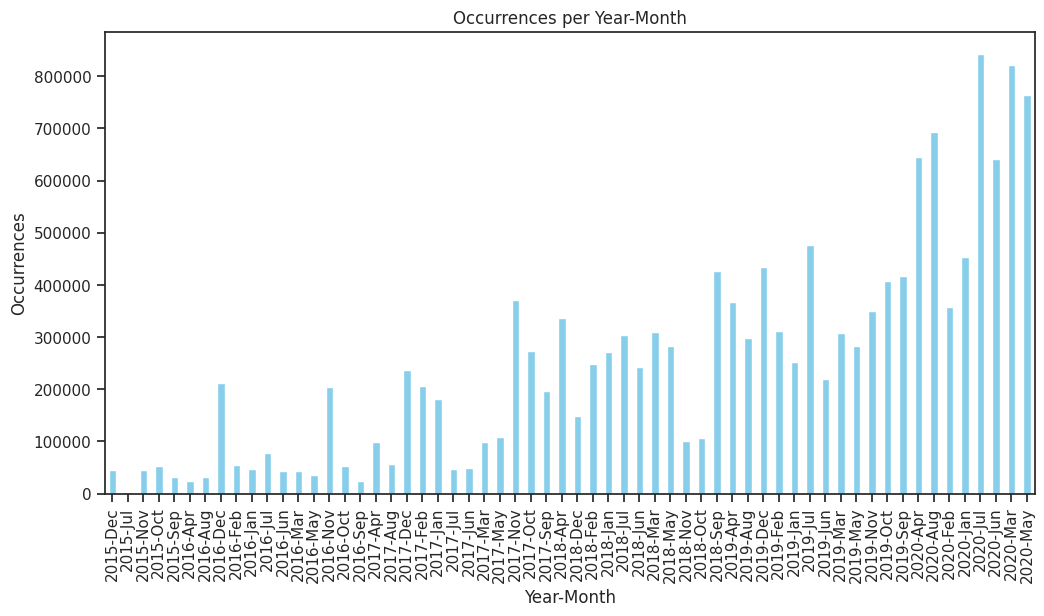

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_date['tanggal'] = pd.to_datetime(df_date['tanggal'], errors='coerce')

# Map Indonesian month names to English month names
month_mapping = {
    'Jan': 'Jan',
    'Feb': 'Feb',
    'Mar': 'Mar',
    'Apr': 'Apr',
    'Mei': 'May',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Agu': 'Aug',
    'Ags': 'Aug',
    'Sep': 'Sep',
    'Okt': 'Oct',
    'Nov': 'Nov',
    'Des': 'Dec'
}

# Extract year-month format from the datetime column
df_date['year_month_format'] = df_date['tanggal'].dt.strftime('%Y-%b')

# Replace Indonesian month names with English month names
df_date['year_month_format'] = df_date['year_month_format'].replace(month_mapping, regex=True)

# Count occurrences of each year and month
year_month_counts = df_date['year_month_format'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 6))
year_month_counts.plot(kind='bar', color='skyblue')
plt.title('Occurrences per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Occurrences')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


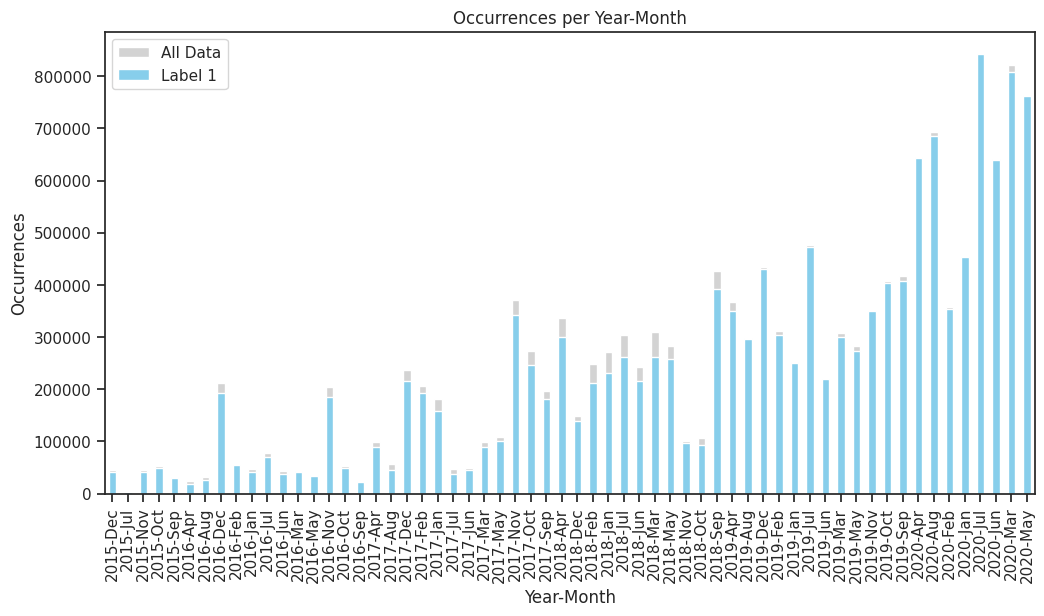

In [ ]:
# Count occurrences of each year and month for all data
all_year_month_counts = df_date['year_month_format'].value_counts().sort_index()

# Count occurrences of each year and month for label 1
label_1_counts = df_date[df_date['label'] == 1]['year_month_format'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot the first set of data (all data)
all_year_month_counts.plot(kind='bar', color='lightgray', label='All Data')

# Plot the second set of data (label 1)
label_1_counts.plot(kind='bar', color='skyblue', label='Label 1')

plt.title('Occurrences per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Occurrences')
plt.legend()
plt.show()

#Modelling

##Adding (Necessary for Modelling)

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

additional_matrix1 = csr_matrix(df['prop_hashtags'].values.reshape(-1, 1))
additional_matrix2 = csr_matrix(df['prop_caps_locked_words'].values.reshape(-1, 1))
additional_matrix3 = csr_matrix(df['Positive_Count_Judul'].values.reshape(-1, 1))
additional_matrix4 = csr_matrix(df['Negative_Count_Judul'].values.reshape(-1, 1))
additional_matrix5 = csr_matrix(df['Positive_Count_Narasi'].values.reshape(-1, 1))
additional_matrix6 = csr_matrix(df['Negative_Count_Narasi'].values.reshape(-1, 1))

X = hstack([X, additional_matrix1, additional_matrix2, additional_matrix3,
            additional_matrix4, additional_matrix5, additional_matrix6])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3760, 14310), (941, 14310), (3760,), (941,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(vsm1, y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(vsm2, y, test_size=0.2, random_state=42)

##Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification
from scipy.stats import randint
# Create an AdaBoost classifier
adaboost_model = AdaBoostClassifier()

# Parameter yang akan dicari secara acak
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Membuat objek RandomizedSearchCV
random_search = RandomizedSearchCV(adaboost_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
y_pred = random_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)

KeyboardInterrupt: ignored

In [ ]:
class_label = ['negative','positive']
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index =class_label, columns=class_label)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report

svm_model = SVC(kernel='linear', C=1.1, class_weight='balanced')

svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model using F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score and classification report
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

F1 Score: 0.9016906700062617

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.39      0.45       164
           1       0.88      0.93      0.90       777

    accuracy                           0.83       941
   macro avg       0.70      0.66      0.68       941
weighted avg       0.82      0.83      0.82       941



In [ ]:
svm_model.support_

array([   0,    5,   17, ..., 3755, 3758, 3759], dtype=int32)

In [ ]:
df.shape, X.shape

((4701, 22), (4701, 14310))

##CatBoost (Main and Best Model Found) (With Cross-Validation)

### Optuna untuk persiapan Catboost

In [ ]:
try:
  from catboost import CatBoostClassifier
except:
  !pip install catboost
  from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
def objective(trial):

    param = {
        'loss_function': 'Logloss',
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.05),
        'iterations':trial.suggest_int("iterations", 300, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'custom_metric' : 'F1'
    }

    cat_model = CatBoostClassifier(**param)

    cat_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=200,verbose=False)

    pred = cat_model.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    return f1

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-24 15:22:02,392] A new study created in memory with name: no-name-004efb49-5593-482b-874a-792039deddff


### Run Model

In [ ]:
# mencoba random search

'''
catboost_model = CatBoostClassifier()
param_grid = {
    'max_depth': [5,6],
    'learning_rate': [0.01, 0.05],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1, 2, 3],
}

# random search
random_search = RandomizedSearchCV(catboost_model, param_distributions= param_grid,
                                   n_iter=10, scoring='f1', cv=3, random_state=69)

random_search.fit(X_train, y_train)

# Prediksi data validasi
y2_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model using F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score and classification report
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Create a CatBoost classifier
catboost_model = CatBoostClassifier(iterations=547, max_depth=5, learning_rate=0.1255, loss_function='Logloss', custom_metric=['F1'])

# Train the CatBoost model
catboost_model.fit(X_train, y_train, verbose=0)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model using F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score and classification report
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

F1 Score: 0.9188529591214155

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.34      0.45       164
           1       0.87      0.97      0.92       777

    accuracy                           0.86       941
   macro avg       0.78      0.65      0.69       941
weighted avg       0.84      0.86      0.84       941



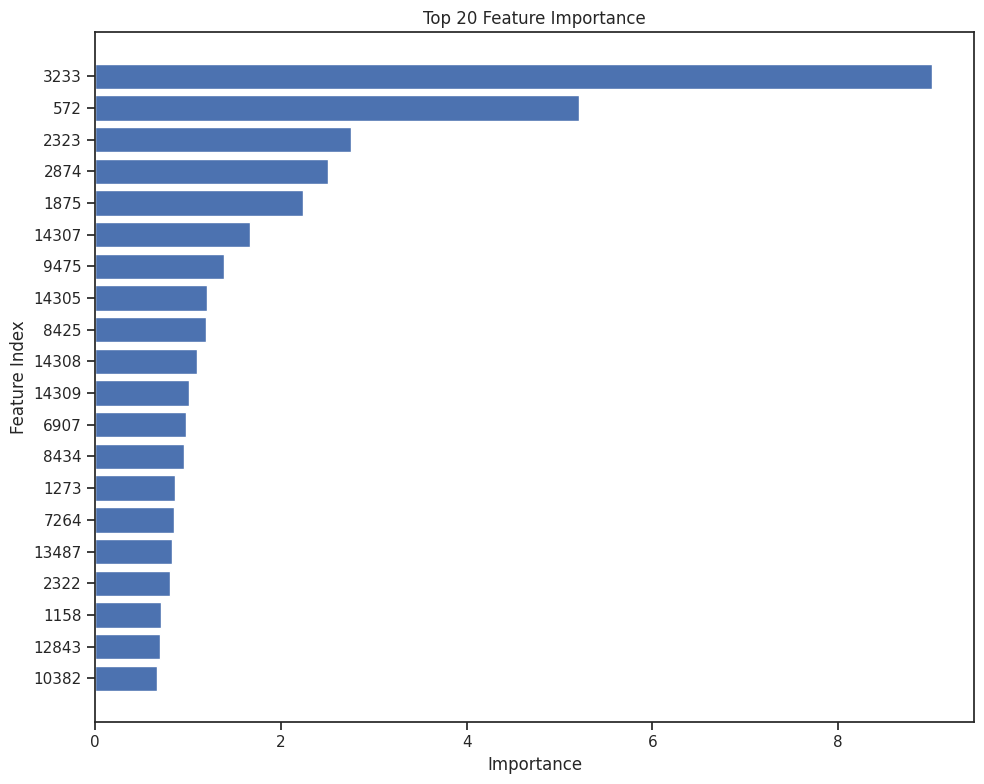

In [ ]:
feature_importances = catboost_model.get_feature_importance()

# Get the top 20 feature indices
sorted_idx = np.argsort(feature_importances)[-20:]

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importances[sorted_idx], align='center')
plt.yticks(range(20), sorted_idx)
plt.title('Top 20 Feature Importance')
plt.ylabel('Feature Index')
plt.xlabel('Importance')
plt.tight_layout()  # Adjust layout to fit feature names
plt.show()

In [ ]:
# cari kata sesuai index di atas, sebagai contoh kita mau cari 3 kata teratas

feature_names = vectorizer.get_feature_names_out()
# Assuming you have an index 'idx'
idx = [3233, 572, 2323]  # Replace with your actual index
word_at_index = feature_names[idx]

print(f"Word at index {idx}: {word_at_index}")

Word at index [3233, 572, 2323]: ['klarikasi' 'bantah' 'hoax']


###Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Create a CatBoost classifier with specified parameters
catboost_model = CatBoostClassifier(iterations=547, max_depth=5, learning_rate=0.1255, loss_function='Logloss', custom_metric=['F1'])

# Define the cross-validation strategy (StratifiedKFold for classification)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store F1 scores
f1_scores = []
accuracy_scores = []

# Perform cross-validation
for train_idx, test_idx in cv_strategy.split(X, y):
    X_train, X_val = pd.DataFrame(X.toarray()).iloc[train_idx], pd.DataFrame(X.toarray()).iloc[test_idx]
    y_train, y_val = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]

    # Train the model on the training data
    catboost_model.fit(X_train, y_train, verbose=0)

    # Make predictions on the validation set
    y_pred = catboost_model.predict(X_val)

    # Evaluate the model using F1 score and accuracy
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # Append scores to the lists
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Print F1 and accuracy scores for each fold
for i, (f1, accuracy) in enumerate(zip(f1_scores, accuracy_scores), start=1):
    print(f"Fold {i} - F1 Score: {f1}, Accuracy: {accuracy}")

# Calculate and print the mean F1 and accuracy scores
mean_f1_score = np.mean(f1_scores)
mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean F1 Score across folds: {mean_f1_score}")
print(f"Mean Accuracy across folds: {mean_accuracy}")

###Comparison with Title and Narration Only

---
Judul

In [ ]:
X_t = vsm1
X_t = hstack([X_t, additional_matrix1, additional_matrix2, additional_matrix3,
            additional_matrix4, additional_matrix5, additional_matrix6])

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Create a CatBoost classifier with specified parameters
catboost_model = CatBoostClassifier(iterations=547, max_depth=5, learning_rate=0.1255, loss_function='Logloss', custom_metric=['F1'])

# Define the cross-validation strategy (StratifiedKFold for classification)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store F1 scores
f1_scores = []
accuracy_scores = []

# Perform cross-validation
for train_idx, test_idx in cv_strategy.split(X_t, y):
    X_train, X_val = pd.DataFrame(X_t.toarray()).iloc[train_idx], pd.DataFrame(X_t.toarray()).iloc[test_idx]
    y_train, y_val = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]

    # Train the model on the training data
    catboost_model.fit(X_train, y_train, verbose=0)

    # Make predictions on the validation set
    y_pred = catboost_model.predict(X_val)

    # Evaluate the model using F1 score and accuracy
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # Append scores to the lists
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Print F1 and accuracy scores for each fold
for i, (f1, accuracy) in enumerate(zip(f1_scores, accuracy_scores), start=1):
    print(f"Fold {i} - F1 Score: {f1}, Accuracy: {accuracy}")

# Calculate and print the mean F1 and accuracy scores
mean_f1_score = np.mean(f1_scores)
mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean F1 Score across folds: {mean_f1_score}")
print(f"Mean Accuracy across folds: {mean_accuracy}")

---
Narasi

In [ ]:
X_n = vsm2
X_n = hstack([X_n, additional_matrix1, additional_matrix2, additional_matrix3,
            additional_matrix4, additional_matrix5, additional_matrix6])

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Create a CatBoost classifier with specified parameters
catboost_model = CatBoostClassifier(iterations=547, max_depth=5, learning_rate=0.1255, loss_function='Logloss', custom_metric=['F1'])

# Define the cross-validation strategy (StratifiedKFold for classification)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store F1 scores
f1_scores = []
accuracy_scores = []

# Perform cross-validation
for train_idx, test_idx in cv_strategy.split(X_n, y):
    X_train, X_val = pd.DataFrame(X_n.toarray()).iloc[train_idx], pd.DataFrame(X_n.toarray()).iloc[test_idx]
    y_train, y_val = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]

    # Train the model on the training data
    catboost_model.fit(X_train, y_train, verbose=0)

    # Make predictions on the validation set
    y_pred = catboost_model.predict(X_val)

    # Evaluate the model using F1 score and accuracy
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # Append scores to the lists
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Print F1 and accuracy scores for each fold
for i, (f1, accuracy) in enumerate(zip(f1_scores, accuracy_scores), start=1):
    print(f"Fold {i} - F1 Score: {f1}, Accuracy: {accuracy}")

# Calculate and print the mean F1 and accuracy scores
mean_f1_score = np.mean(f1_scores)
mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean F1 Score across folds: {mean_f1_score}")
print(f"Mean Accuracy across folds: {mean_accuracy}")

##XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Evaluate the model using F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score and classification report
print(f"F1 Score: {f1}")

# Print accuracy and classification report
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)

##LightGBM

### Optuna LGBM

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):

    param = {
        'metric': 'binary_logloss',
        'learning_rate': trial.suggest_uniform('learning_rate', 0.05, 0.1),
        'iterations':trial.suggest_int("iterations", 300, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'num_leaves': trial.suggest_int('num_leaves', 8, 10),
        'objective' : 'binary'
    }

    lgb_model = lgb.LGBMClassifier(**param)

    lgb_model.fit(X_train,y_train,eval_set=[(X_test,y_test)])

    pred = lgb_model.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    return f1

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

### Running Model

In [ ]:
import lightgbm as lgb

In [ ]:
# Create a LightGBM classifier
lgb_model = lgb.LGBMClassifier(num_leaves=8, depth=5, learning_rate=0.1, objective='binary', metric='binary_logloss')

# Train the LightGBM model
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Evaluate the model using F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score and classification report
print(f"F1 Score: {f1}")

# Print accuracy and classification report
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)

##Naive Bayesian

In [ ]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

#Naive Bayesian
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
y_pred = naive_bayes_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)


F1 Score: 0.9057928613224108
Accuracy: 0.8289054197662061

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.04      0.07       164
           1       0.83      1.00      0.91       777

    accuracy                           0.83       941
   macro avg       0.75      0.52      0.49       941
weighted avg       0.80      0.83      0.76       941



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Naive Bayes classifier (Multinomial)
naive_bayes_model = MultinomialNB()

param_dist = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Contoh parameter alpha untuk model MultinomialNB
}
random_search = RandomizedSearchCV(naive_bayes_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
y_pred = random_search.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)



Best Parameters: {'alpha': 1.0}
F1 Score: 0.9057928613224108
Accuracy: 0.8289054197662061

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.04      0.07       164
           1       0.83      1.00      0.91       777

    accuracy                           0.83       941
   macro avg       0.75      0.52      0.49       941
weighted avg       0.80      0.83      0.76       941



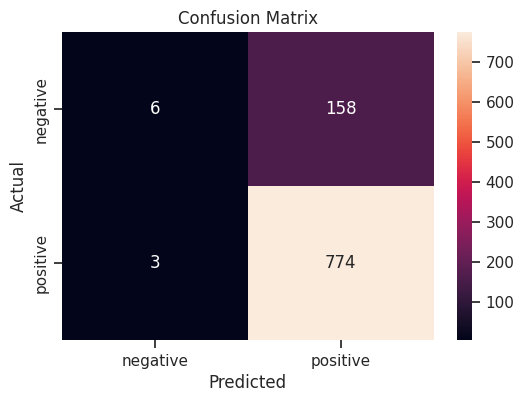

In [ ]:
class_label = ['negative','positive']
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index =class_label, columns=class_label)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Deep Learning

###Preparation

In [ ]:
import tensorflow as tf

In [ ]:
tf_X = df[['judul_X', 'narasi_X']]

In [ ]:
tf_X.head(1)

In [ ]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)
token2 = tf.keras.preprocessing.text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(tf_X['judul_X']))
token2.fit_on_texts(list(tf_X['narasi_X']))
tf_X_seq = token.texts_to_sequences(tf_X['judul_X'])
tf_X_nar_seq = token2.texts_to_sequences(tf_X['narasi_X'])

#zero pad the sequences
tf_X_pad = tf.keras.preprocessing.sequence.pad_sequences(tf_X_seq, maxlen=max_len)
tf_X_nar_pad = tf.keras.preprocessing.sequence.pad_sequences(tf_X_nar_seq, maxlen=max_len)

word_index = token.word_index
word_index2 = token2.word_index

In [ ]:
tf_X_nar_pad.shape

In [ ]:
tf_X_pad.shape

In [ ]:
tf_X_new = pd.concat([tf_X.drop(['judul_X', 'narasi_X'], axis=1, inplace=True), pd.DataFrame(tf_X_nar_pad), pd.DataFrame(tf_X_pad)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tf_X_new, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(tf_X_new, y, test_size=0.4, random_state=42)

In [ ]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_val = label_encoder.fit_transform(y_val)

###Bidirectional LSTM with CNN

In [ ]:
# Create your model
vocab_size = 10000
embedding_dim = 50
sequence_length = 3000
num_classes = 2

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
cnn_model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

bilstm_model = tf.keras.Sequential()
bilstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3, return_sequences=True)))
bilstm_model.add(tf.keras.layers.GlobalMaxPooling1D())

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(sequence_length,)))
model.add(cnn_model)
model.add(bilstm_model)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val))

In [ ]:
model.evaluate(X_test, y_test)

---
Hanya seed yang beruntung

In [ ]:
#Cross-Validation
from sklearn.model_selection import KFold

tf_X_new_num = X.toarray()
y = np.array(y)

# Assuming tf_X_new_num and y are your feature and target data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(tf_X_new_num, y):
    X_train, X_test = tf_X_new_num[train_index], tf_X_new_num[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = tf.convert_to_tensor(X_train)
    y_train = tf.convert_to_tensor(y_train)
    X_test = tf.convert_to_tensor(X_test)
    y_test = tf.convert_to_tensor(y_test)

    vocab_size = 10000
    embedding_dim = 50
    sequence_length = 14380
    num_classes = 2

    cnn_model = tf.keras.Sequential()
    cnn_model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
    cnn_model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    bilstm_model = tf.keras.Sequential()
    bilstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3, return_sequences=True)))
    bilstm_model.add(tf.keras.layers.GlobalMaxPooling1D())

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(sequence_length,)))
    model.add(cnn_model)
    model.add(bilstm_model)
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=4, verbose=1, validation_split=0.2)

    results = model.evaluate(X_test, y_test)
    print("Test Loss:", results[0])
    print("Test Accuracy:", results[1])

###BERT (RAM Tidak Cukup)

In [ ]:
'''
import tensorflow_hub as hub
tf_X = df[['judul_X', 'narasi_X']]
'''

In [ ]:
'''
from transformers import BertTokenizer, TFBertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)
'''

In [ ]:
'''
texts = tf_X.apply(lambda row: row['judul_X'] + ' ' + row['narasi_X'], axis=1).tolist()
encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
output = model(encoded_input)
'''

# Interpretasi Hasil

1. Berdasarkan visualisasi kata yang sudah kami buat, kami menemukan bahwa terdapat beberapa kata yang berasosiasi dengan berita hoaks atau bukan hoaks.


---


**Berita Hoaks**
- Untuk judul berita hoaks, kata 'video' dan 'foto' menjadi kata yang paling sering muncul.
- Untuk narasi berita hoaks, kata 'jokowi', 'foto', dan 'video' merupakan 3 kata yang paling sering muncul.

Hal ini masuk akal karena pembuat berita hoaks pasti ingin agar berita yang mereka sebarkan dipercayai oleh masyarakat luas, salah satunya dengan bukti foto atau video.


---


**Berita Bukan Hoaks**
- Untuk judul berita bukan hoaks, kata 'klarifikasi', 'kait', 'bantah' menjadi kata yang paling sering muncul.
- Untuk narasi berita bukan hoaks, kata 'Indonesia', 'hoax', dan 'berita' merupakan kata yang paling sering muncul.

Hal ini masuk akal karena berita fakta umumnya dikeluarkan untuk mem**bantah**/meng**klarifikasi terkait berita hoax** yang beredar

---



**Rekomendasi:**

Sebagai pengguna media sosial yang bijak, alangkah baiknya kita pastikan asal dan sumber berita tersebut aktual dan faktual. Lihat apakah berita tersebut fakta atau opini saja dengan memastikan apakah alamat URL situs tersebut terverifikasi resmi.

Umumnya berita hoax agar terlihat “terpercaya” didukung oleh foto dan video. Dengan kecanggihan teknologi, foto dan video tersebut dapat diedit untuk mempengaruhi orang lain. Kita bisa menguji kebenaran foto tersebut dengan membandingkan foto tersebut dengan foto serupa melalui Google Lens.


Referensi:

https://www.djkn.kemenkeu.go.id/kanwil-jakarta/baca-artikel/16438/Mari-Bersama-Lawan-Hoax-di-Media-Sosial.html

---
2. Melanjutkan hasil interpretasi pada poin 1, kami menduga bahwa biasanya kalimat pada judul dan narasi yang hoaks akan lebih panjang untuk meyakinkan pembaca.

Hal yang cukup menarik adalah, berkebalikan dengan dugaan awal kami, rata-rata jumlah kata pada judul berita hoaks lebih sedikit daripada rata-rata jumlah kata pada judul berita bukan hoaks. Namun, jika dilihat secara keseluruhan, terdapat beberapa berita hoaks yang memiliki jumlah kata lebih dari rata-rata.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


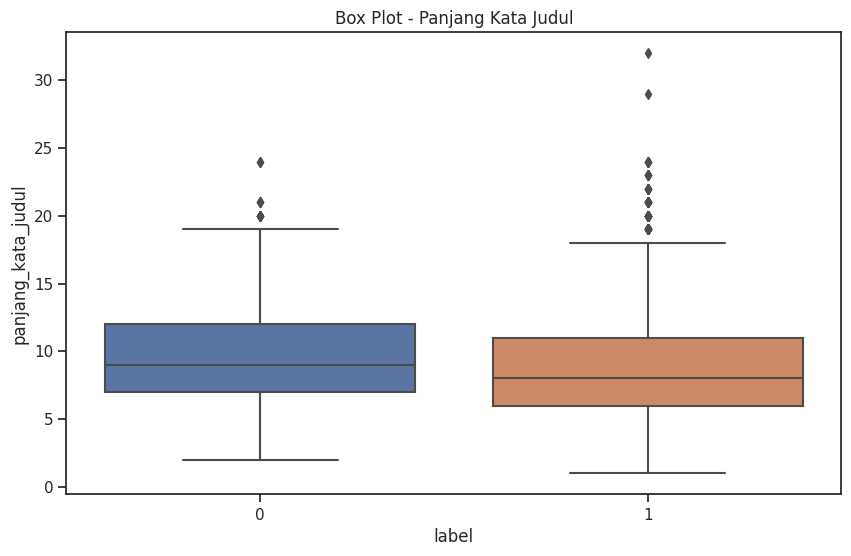

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x= df['label'], y=df['panjang_kata_judul'], data=df)
plt.title('Box Plot - Panjang Kata Judul')
plt.show()

Hal yang tidak jauh berbeda berlaku untuk narasi berita hoaks. Rata-rata jumlah kata pada narasi berita hoaks hampir sama dengan rata-rata jumlah kata pada judul berita bukan hoaks. Namun, jika dilihat secara keseluruhan, terdapat beberapa narasi berita hoaks yang memiliki jumlah kata lebih dari rata-rata.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


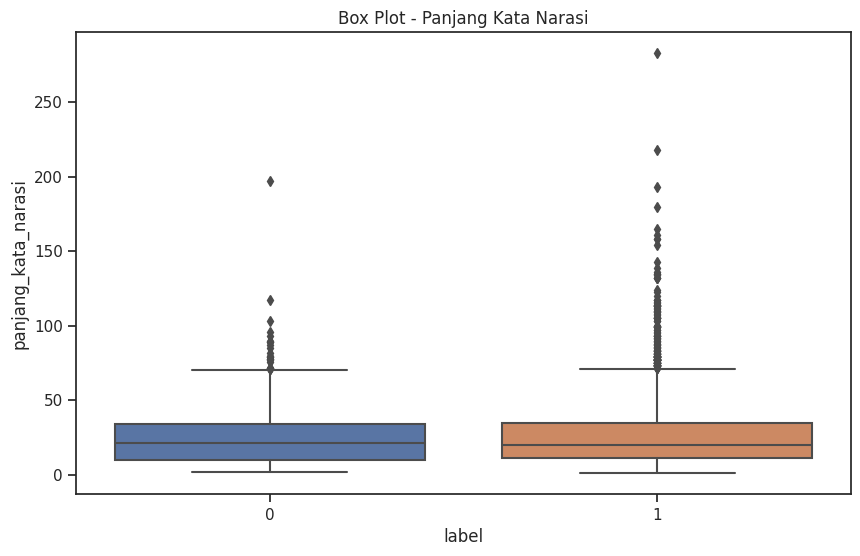

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['label'], y=df['panjang_kata_narasi'], data=df)
plt.title('Box Plot - Panjang Kata Narasi')
plt.show()

---
3. Berdasarkan plot feature importance di bawah, kita dapatkan 3 kata yang paling berkontribusi dalam mempengaruhi prediksi model, yakni kata 'klarifikasi', 'bantah', dan 'hoax'. Ketiga kata tersebut dinilai vital untuk memengaruhi pilihan model untuk mengklasifikasikan observasi sebagai hoaks atau bukan.

Saran:

Ketiga kata tersebut dan mungkin beberapa kata berikutnya yang dinilai penting sesuai dengan visualisasi berikut-berikutnya dapat dijadikan tumpuan evaluasi sebagai pengenalan hoaks atau bukannya suatu observasi ke depannya.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


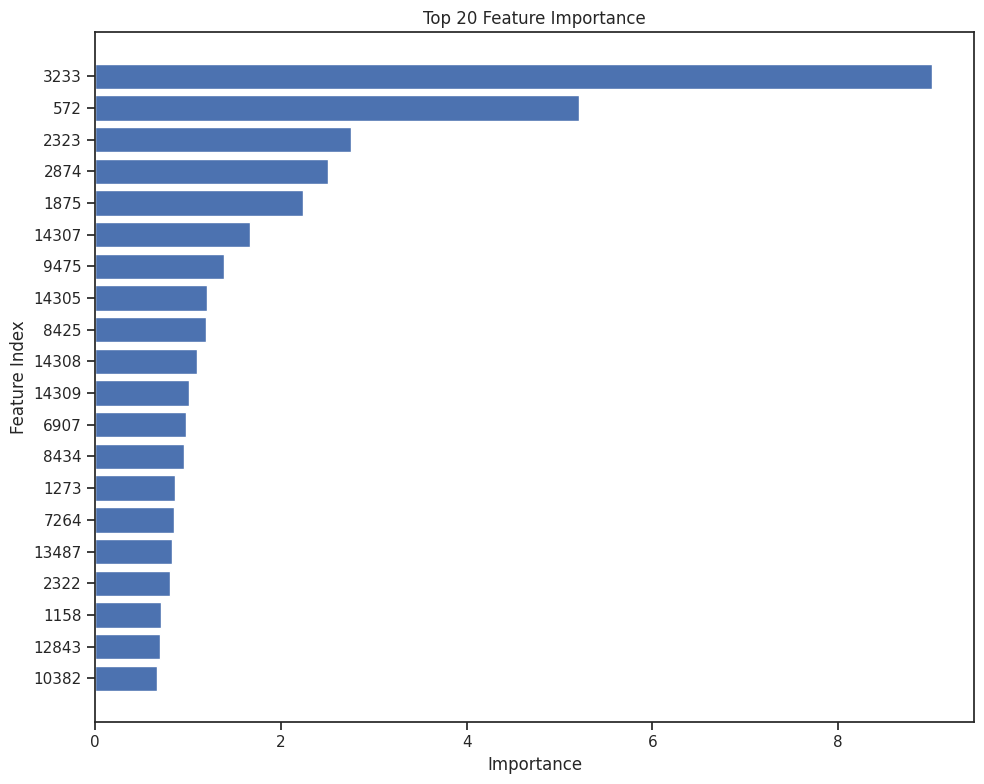

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importances[sorted_idx], align='center')
plt.yticks(range(20), sorted_idx)
plt.title('Top 20 Feature Importance')
plt.ylabel('Feature Index')
plt.xlabel('Importance')
plt.tight_layout()  # Adjust layout to fit feature names
plt.show()

In [ ]:
# cari kata sesuai index di atas, sebagai contoh kita mau cari 3 kata teratas

feature_names = vectorizer.get_feature_names_out()
# Assuming you have an index 'idx'
idx = [3233, 572, 2323]  # Replace with your actual index
word_at_index = feature_names[idx]

print(f"Word at index {idx}: {word_at_index}")

Word at index [3233, 572, 2323]: ['klarikasi' 'bantah' 'hoax']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
4. Kami membuat visualisasi dengan fokus utama proporsi/perbandingan hoaks terhadap non-hoaks. Ditemukan bahwa hoaks mulai memiliki proporsi/perbandingan yang sangat tinggi dibanding non-hoaks saat Desember 2019, bertepatan dengan dimulainya pandemi Covid-19. Jumlah observasi yang meningkat bisa disebabkan semakin banyaknya penduduk Indonesia yang lebih terekspos ke sosial media dan kehangatan berita terkait pandemi.

Saran:

Sehubungan dengan kejadian penting yang juga berdampak ke Indonesia, sudah selayaknya pihak Kominfo lebih berjaga-jaga terkait hoaks yang bermunculan lebih banyak. Dengan mengenali saat-saat demikian sebagai kesempatan untuk hoaks menyebar, kiranya penanganan yang lebih ketat di saat-saat demikian di masa depan bisa lebih teratur dari antisipasi berdasarkan hasil insight.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


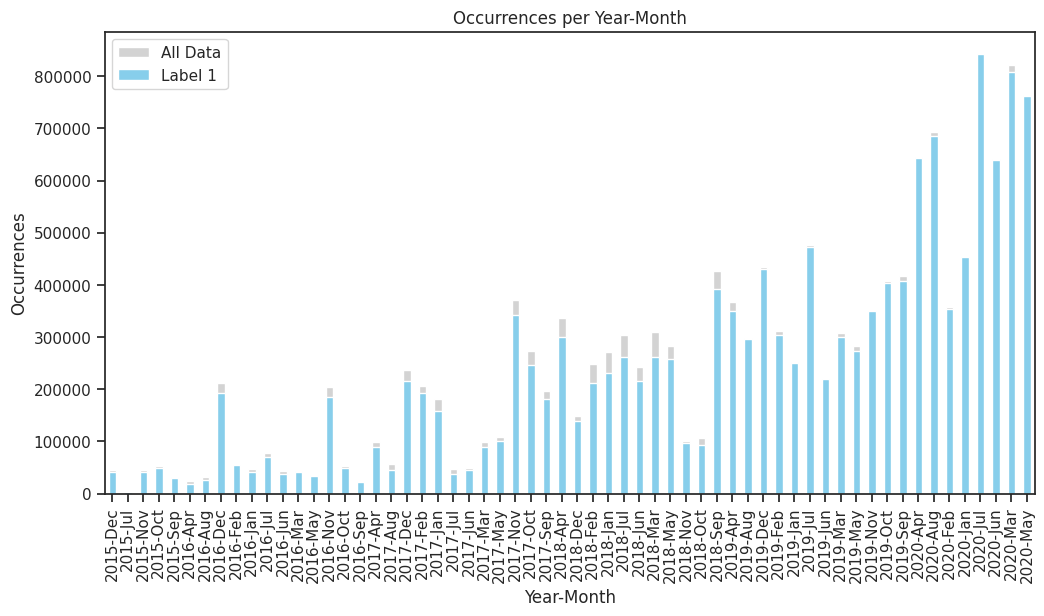

In [ ]:
# Count occurrences of each year and month for all data
all_year_month_counts = df_date['year_month_format'].value_counts().sort_index()

# Count occurrences of each year and month for label 1
label_1_counts = df_date[df_date['label'] == 1]['year_month_format'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot the first set of data (all data)
all_year_month_counts.plot(kind='bar', color='lightgray', label='All Data')

# Plot the second set of data (label 1)
label_1_counts.plot(kind='bar', color='skyblue', label='Label 1')

plt.title('Occurrences per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Occurrences')
plt.legend()
plt.show()

---
5. Berkaitan dengan poin nomor 4, kami pun mencari tahu topik hoaks apa yang paling sering muncul. Sesuai dugaan, topik hoaks yang paling banyak bermunculan berkaitan dengan virus Corona.

Dari visualisasi yang telah dilakukan, terungkap bahwa 4 dari 10 judul hoaks yang paling umum berkaitan dengan isu pandemi Covid-19, sementara 3 dari 10 narasi hoaks yang sering muncul juga terkait dengan tema yang sama. Hal ini menyoroti signifikansi peran topik yang sangat hangat kala itu, yakni pandemi dalam menyebarkan informasi yang salah dan perlu mendapatkan perhatian lebih lanjut.

Referensi:

https://www.kominfo.go.id/content/detail/27755/kominfo-hingga-juni-terdapat-850-hoaks-terkait-covid-19/0/sorotan_media
https://www.its.ac.id/news/2020/03/27/sumber-masalah-sesungguhnya-corona-atau-media/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


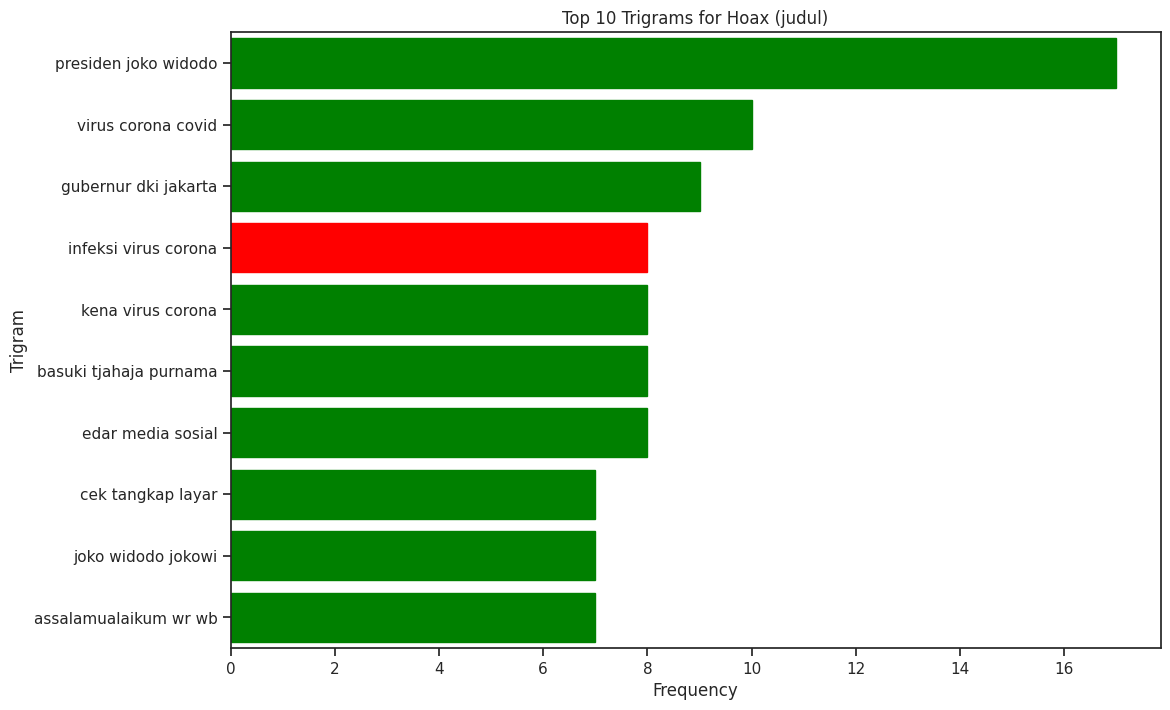

In [ ]:
# UNTUK JUDUL

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Trigram', data=trigram_df.head(10))

highlighted_trigrams = ["sebar virus corona", "pasien virus corona", "infeksi virus corona", "posit virus corona"]
colors = ['red' if trigram in highlighted_trigrams else 'green' for trigram in trigram_df['Trigram']]

for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

plt.title('Top 10 Trigrams for Hoax (judul)')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


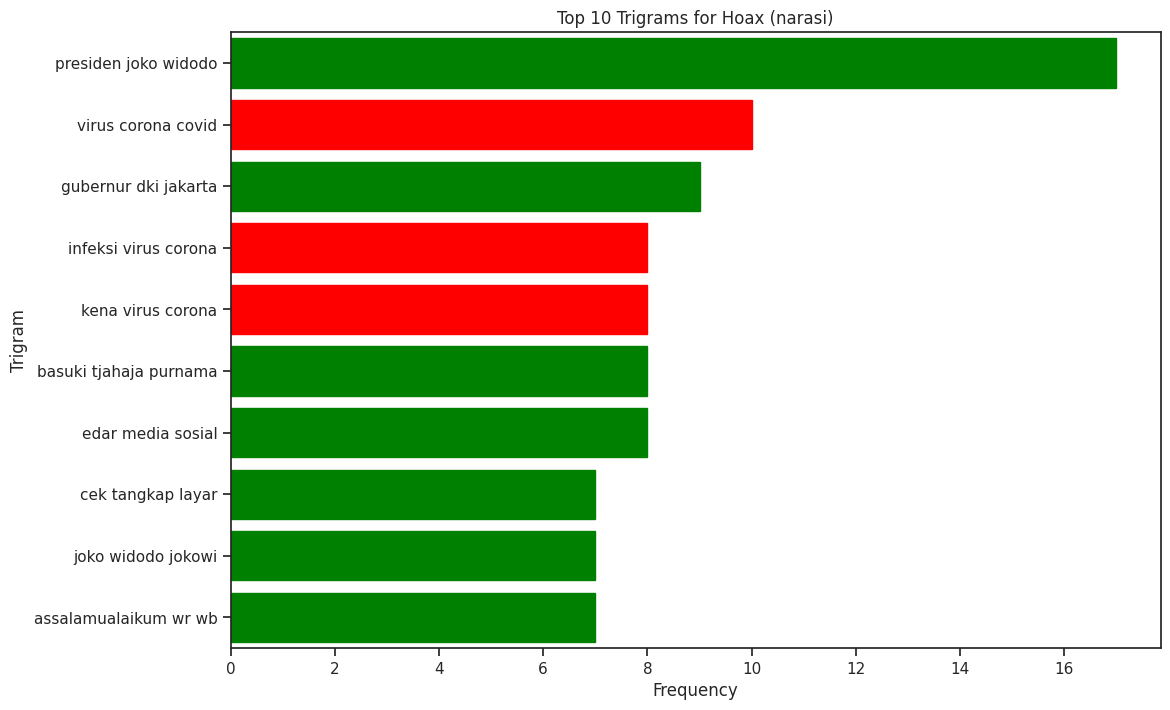

In [ ]:
#UNTUK NARASI

trigrams = generate_ngrams(all_text, 3)
trigram_freq = Counter(trigrams)
trigram_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency'])

trigram_df = trigram_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Trigram', data=trigram_df.head(10))

highlighted_trigrams = ["virus corona covid", "infeksi virus corona", "kena virus corona"]
colors = ['red' if trigram in highlighted_trigrams else 'green' for trigram in trigram_df['Trigram']]

for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

plt.title('Top 10 Trigrams for Hoax (narasi)')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

---
6. Kami membuat visualisasi Multidimensional Scaling untuk pembagian topik berdasarkan jarak dari data yang terlabel hoaks. Kami memutuskan untuk membuat dua visualisasi, satu untuk judul, satu lagi untuk narasi.

Untuk judul (visualisasi di bawah ini), kami mengambil 4 kelas yang terpisah dengan *multidimensional scaling*.

Kelas 1 lebih berkaitan dengan hoaks yang lebih bertujuan menyerang kinerja pemerintah dengan sentuhan topik-topik sensitif terkait agama, etnis tertentu, dan konspirasi.

Kelas 2 lebih berkaitan dengan hoaks di bidang keamanan negara, terlihat dari sosok Prabowo yang cukup memiliki sejarah dengan bidang keamanan di Indonesia, diiringi dengan kata-kata TNI dan polisi.

Kelas 3 tidak ada yang begitu unik, hanya kumpulan hoaks-hoaks dari semua topik. Terjelaskan dengan posisinya sangat dekat dengan tengah-tengah dari ketiga kelas lainnya.

Kelas 4 lebih berkaitan dengan hoaks terkait isu pandemi covid-19, jelas dengan kata-kata yang erat dengan isu tersebut.

In [ ]:
pyLDAvis.lda_model.prepare(lda1, vsmidf1, vectorizer1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.043219  0.125896       1        1  28.326087
2     -0.101136 -0.102399       2        1  25.176258
1      0.008622  0.013577       3        1  23.276678
0      0.135732 -0.037074       4        1  23.220977, topic_info=          Term        Freq       Total Category  logprob  loglift
2487    jokowi  207.000000  207.000000  Default  30.0000  30.0000
81         air   46.000000   46.000000  Default  29.0000  29.0000
6153     virus  119.000000  119.000000  Default  28.0000  28.0000
1131    corona  155.000000  155.000000  Default  27.0000  27.0000
1139     covid  122.000000  122.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3140    larang   14.328275   28.718102   Topic4  -6.0166   0.7648
1673      foto   24.870703  268.113597   Topic4  -5.4652  -0.9176
4531  presiden   18.286317   99.659044   Topic4  -5.7727  -0.2355
102     akibat   15.070193   41.497015   Topic4  -5.9661   0.4472
4410       pki   15.359852   56.810664   Topic4  -5.9471   0.1521

[284 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
9         1  0.972695   abdul
29        3  0.899145  adakan
53        1  0.904132   agama
53        3  0.033486   agama
53        4  0.066973   agama
...     ...       ...     ...
6206      3  0.167304   warga
6206      4  0.076047   warga
6247      1  0.907908  widodo
6323      1  0.885028  yusril
6352      4  0.916985    zona

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

Untuk narasi (visualisasi di bawah ini), kami mengambil 3 kelas yang terpisah dengan *multidimensional scaling*.

Kelas 1 lebih berkaitan dengan hoaks terkait covid-19 yang dikaitkan dengan negara Cina.

Kelas 2 lebih berkaitan dengan hoaks di bidang keamanan negara, terlihat dari kata-kata TNI dan polisi.

Kelas 3 berkaitan dengan hoaks dengan subjek utama presiden Joko Widodo dengan nuansa agama yang dibawa-bawa ke topik tersebut.

In [ ]:
pyLDAvis.lda_model.prepare(lda2, vsmidf2, vectorizer2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.024312 -0.096053       1        1  37.135123
0     -0.096543  0.027272       2        1  31.746792
2      0.072232  0.068781       3        1  31.118084, topic_info=            Term        Freq       Total Category  logprob  loglift
2284      corona  198.000000  198.000000  Default  30.0000  30.0000
2068       china  166.000000  166.000000  Default  29.0000  29.0000
12371      virus  220.000000  220.000000  Default  28.0000  28.0000
11857        tni   91.000000   91.000000  Default  27.0000  27.0000
6794       makan   95.000000   95.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8210       orang   70.525473  380.065412   Topic3  -5.6148  -0.5170
4556   indonesia   69.128963  404.082568   Topic3  -5.6348  -0.5983
9421      rakyat   43.469561  123.984003   Topic3  -6.0987   0.1193
8713    perintah   43.972132  138.792415   Topic3  -6.0872   0.0180
6278        laku   37.735962   99.459213   Topic3  -6.2401   0.1982

[259 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
52         1  0.101184     aceh
52         2  0.860062     aceh
112        3  0.957203    adzan
157        1  0.105582  agustus
157        2  0.844658  agustus
...      ...       ...      ...
12499      2  0.195558    warga
12499      3  0.170050    warga
12592      2  0.243688   widodo
12592      3  0.761524   widodo
12832      3  0.947103     zeal

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

Saran:

Melalui informasi yang didapat dari pengelompokkan topik-topik hoaks, Kominfo mampu mengenali topik yang perlu pengawasan ekstra untuk hoaks. Topik utama yang sangat rentan untuk menjadi topik hoaks antara lain: Pemerintah/Presiden, bidang Keamanan Negara, dan berita hangat (dalam data kali ini adalah Covid-19) di saat itu.

7. Kami membuat visualisasi sentimen dengan pie chart. Kami membuat pie chart untuk membandingkan presentase sentimen pada berita hoax dengan berita fakta. Tidak seperti dugaan awal, presentase sentimen negatif pada berita hoax dan berita fakta sama-sama lebih tinggi dari pada sentimen positif.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Presentase Sentimen pada Narasi Berita Hoax')

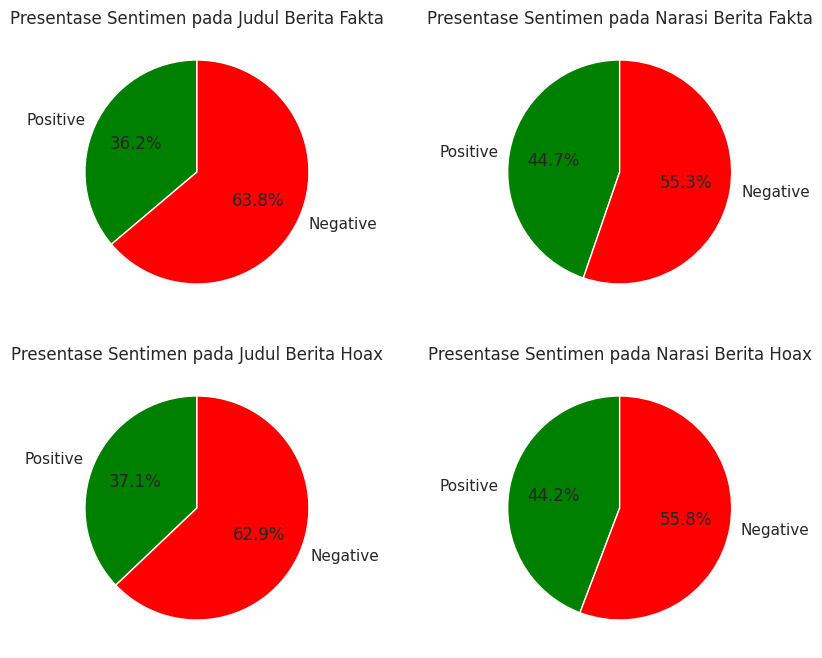

In [ ]:
#Membuat df
sentimen_judul_fakta = df[df['label']==0][['Positive_Count_Judul','Negative_Count_Judul']]
sentimen_narasi_fakta = df[df['label']==0][['Positive_Count_Narasi','Negative_Count_Narasi']]
sentimen_judul_hoax = df[df['label']==1][['Positive_Count_Judul','Negative_Count_Judul']]
sentimen_narasi_hoax = df[df['label']==1][['Positive_Count_Narasi','Negative_Count_Narasi']]

# Sum each column
sum_positive1 = sentimen_judul_fakta['Positive_Count_Judul'].sum()
sum_negative1 = sentimen_judul_fakta['Negative_Count_Judul'].sum()
sum_positive2 = sentimen_narasi_fakta['Positive_Count_Narasi'].sum()
sum_negative2 = sentimen_narasi_fakta['Negative_Count_Narasi'].sum()
sum_positive3 = sentimen_judul_hoax['Positive_Count_Judul'].sum()
sum_negative3 = sentimen_judul_hoax['Negative_Count_Judul'].sum()
sum_positive4 = sentimen_narasi_hoax['Positive_Count_Narasi'].sum()
sum_negative4 = sentimen_narasi_hoax['Negative_Count_Narasi'].sum()

labels = ['Positive', 'Negative']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].pie([sum_positive1, sum_negative1], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0, 0].set_title('Presentase Sentimen pada Judul Berita Fakta')

axs[0, 1].pie([sum_positive2, sum_negative2], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0, 1].set_title('Presentase Sentimen pada Narasi Berita Fakta')

axs[1, 0].pie([sum_positive3, sum_negative3], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1, 0].set_title('Presentase Sentimen pada Judul Berita Hoax')

axs[1, 1].pie([sum_positive4, sum_negative4], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1, 1].set_title('Presentase Sentimen pada Narasi Berita Hoax')

## Interpretasi Detail Terkait Model

---
Terkait klasifikasi hoaks, melalui model utama yang kami gunakan, kami temukan bahwa klasifikasi dengan judul saja cukup untuk menentukan hoaks atau tidak. Narasi saja memang tetap cukup bisa, tetapi tidak seoptimal menggunakan judul saja. Selain itu, kami juga menemukan dengan SVM bahwa banyak observasi yang penting dalam menentukan pemisah hoaks atau tidak. Hal tersebut berarti pembuatan klasifikasi hoaks cukup kompleks untuk bisa sangat akurat.


Model yang kami gunakan pada akhirnya adalah **catboost** untuk klasifikasi dikarenakan **akurasi yang cukup bagus** dan **interpretasi yang bisa didapatkan.** Kami lebih memfokuskan untuk mendapat akurasi yang sesuai untuk setiap kelas, meskipun data tergolong *imbalanced* sehingga kami gunakan metriks F1-Score. Meskipun kami sebenarnya mendapatkan parameter yang lebih spesifik melalui optuna, estimasi waktu yang diperlukan untuk *fitting* model adalah lebih dari satu jam sehingga sulit untuk dilakukan *cross-validation*. Dengan demikian, kami memutuskan untuk menggunakan parameter yang tidak terlalu variatif pada model akhir kami dikarenakan keterbatasan waktu dan fasilitas yang bisa kami akses.

Terkait model yang bisa bagus untuk digunakan juga adalah dengan menerapkan *fine-tuning* model BERT yang sudah dioptimisasi untuk bahasa Indonesia dan mengaplikasikannya untuk klasifikasi biner. Kami menemukannya di huggingface dengan module Transformers yang kemudian terhubung ke module torch dan tensorflow. Akan tetapi, keterbatasan RAM di google colab tidak memungkinkan kami melakukan *fine-tuning* BERT yang memiliki 11 juta parameter.

Kami juga mencoba membuat model *deep learning* dengan tensorflow dengan menerapkan GRU, LSTM, serta penggabungan Bidirectional LSTM dan Convolutional Neural Network. Hanya saja, dengan jumlah observasi yang tidak banyak, model sangat rentan dengan overfitting, bahkan dengan *layer*, nodus, dan epoch yang sedikit.


---



Saran:

Apabila Kominfo ingin membuat model untuk mengklasifikasikan hoaks untuk menggunakan BERT dan *deep learning* secara umum apabila ingin mencapai akurasi maksimum apabila ukuran data memadai. Secara utama, BERT yang hanya memerlukan sedikit perubahan/penambahan arsitektur model untuk klasifikasi seharusnya bisa memberikan hasil yang bagus asal memiliki fasilitas yang memadai.